In [1]:
import os
import random
import argparse
import yaml
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms

from datasets import build_dataset
from datasets.utils import build_data_loader
import clip
from utils import *

In [2]:
def get_arguments():

    parser = argparse.ArgumentParser()
    parser.add_argument('--config', dest='config', help='settings of Tip-Adapter in yaml format')
    args = parser.parse_args(args=[])

    return args

In [3]:
def run_tip_adapter(cfg, cache_keys, cache_values, val_features, val_labels, test_features, test_labels, clip_weights):
    
    print("\n-------- Searching hyperparameters on the val set. --------")

    # Zero-shot CLIP
    clip_logits = 100. * val_features @ clip_weights
    acc = cls_acc(clip_logits, val_labels)
    print("\n**** Zero-shot CLIP's val accuracy: {:.2f}. ****\n".format(acc))

    # Tip-Adapter
    beta, alpha = cfg['init_beta'], cfg['init_alpha']
    
    affinity = val_features @ cache_keys
    cache_logits = ((-1) * (beta - beta * affinity)).exp() @ cache_values
    
    tip_logits = clip_logits + cache_logits * alpha
    acc = cls_acc(tip_logits, val_labels)
    print("**** Tip-Adapter's val accuracy: {:.2f}. ****\n".format(acc))

    # Search Hyperparameters
    best_beta, best_alpha = search_hp(cfg, cache_keys, cache_values, val_features, val_labels, clip_weights)


    print("\n-------- Evaluating on the test set. --------")

    # Zero-shot CLIP
    clip_logits = 100. * test_features @ clip_weights
    acc = cls_acc(clip_logits, test_labels)
    print("\n**** Zero-shot CLIP's test accuracy: {:.2f}. ****\n".format(acc))

    # Tip-Adapter    
    affinity = test_features @ cache_keys
    cache_logits = ((-1) * (best_beta - best_beta * affinity)).exp() @ cache_values
    
    tip_logits = clip_logits + cache_logits * best_alpha
    acc = cls_acc(tip_logits, test_labels)
    print("**** Tip-Adapter's test accuracy: {:.2f}. ****\n".format(acc))
    # 返回tip_logits
    return tip_logits,acc

In [4]:
def run_tip_adapter_F(cfg, cache_keys, cache_values, val_features, val_labels, test_features, test_labels, clip_weights, clip_model, train_loader_F):
    
    # Enable the cached keys to be learnable
    adapter = nn.Linear(cache_keys.shape[0], cache_keys.shape[1], bias=False).to(clip_model.dtype).cuda()
    adapter.weight = nn.Parameter(cache_keys.t())
    
    optimizer = torch.optim.AdamW(adapter.parameters(), lr=cfg['lr'], eps=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cfg['train_epoch'] * len(train_loader_F))
    
    beta, alpha = cfg['init_beta'], cfg['init_alpha']
    best_acc, best_epoch = 0.0, 0

    for train_idx in range(cfg['train_epoch']):
        # Train
        adapter.train()
        correct_samples, all_samples = 0, 0
        loss_list = []
        print('Train Epoch: {:} / {:}'.format(train_idx, cfg['train_epoch']))

        for i, (images, target) in enumerate(tqdm(train_loader_F)):
            images, target = images.cuda(), target.cuda()
            with torch.no_grad():
                image_features = clip_model.encode_image(images)
                image_features /= image_features.norm(dim=-1, keepdim=True)

            affinity = adapter(image_features)
            cache_logits = ((-1) * (beta - beta * affinity)).exp() @ cache_values
            clip_logits = 100. * image_features @ clip_weights
            tip_logits = clip_logits + cache_logits * alpha

            loss = F.cross_entropy(tip_logits, target)

            acc = cls_acc(tip_logits, target)
            correct_samples += acc / 100 * len(tip_logits)
            all_samples += len(tip_logits)
            loss_list.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

        current_lr = scheduler.get_last_lr()[0]
        print('LR: {:.6f}, Acc: {:.4f} ({:}/{:}), Loss: {:.4f}'.format(current_lr, correct_samples / all_samples, correct_samples, all_samples, sum(loss_list)/len(loss_list)))

        # Eval
        adapter.eval()

        affinity = adapter(test_features)
        cache_logits = ((-1) * (beta - beta * affinity)).exp() @ cache_values
        clip_logits = 100. * test_features @ clip_weights
        tip_logits = clip_logits + cache_logits * alpha
        acc = cls_acc(tip_logits, test_labels)

        print("**** Tip-Adapter-F's test accuracy: {:.2f}. ****\n".format(acc))
        if acc > best_acc:
            best_acc = acc
            best_epoch = train_idx
            torch.save(adapter.weight, cfg['cache_dir'] + "/best_F_" + str(cfg['shots']) + "shots.pt")
    
    adapter.weight = torch.load(cfg['cache_dir'] + "/best_F_" + str(cfg['shots']) + "shots.pt")
    print(f"**** After fine-tuning, Tip-Adapter-F's best test accuracy: {best_acc:.2f}, at epoch: {best_epoch}. ****\n")

    print("\n-------- Searching hyperparameters on the val set. --------")

    # Search Hyperparameters
    best_beta, best_alpha = search_hp(cfg, cache_keys, cache_values, val_features, val_labels, clip_weights, adapter=adapter)

    print("\n-------- Evaluating on the test set. --------")
   
    affinity = adapter(test_features)
    cache_logits = ((-1) * (best_beta - best_beta * affinity)).exp() @ cache_values
    
    tip_logits = clip_logits + cache_logits * best_alpha
    acc = cls_acc(tip_logits, test_labels)
    print("**** Tip-Adapter-F's test accuracy: {:.2f}. ****\n".format(max(best_acc, acc)))
    

In [5]:
def get_arguments():

    parser = argparse.ArgumentParser()
    parser.add_argument('--config', dest='config', help='settings of Tip-Adapter in yaml format',default='configs/eurosat.yaml')
    args ,unknown = parser.parse_known_args( )

    return args

# Load config file

args = get_arguments()
if args.config is not None:
    assert os.path.exists(args.config), "Config file does not exist"
else:
    print("No config file specified.")

In [6]:
# Load config file
args = get_arguments()
assert (os.path.exists(args.config))

cfg = yaml.load(open(args.config, 'r'), Loader=yaml.Loader)

In [7]:
cfg

{'root_path': '',
 'load_cache': False,
 'load_pre_feat': False,
 'search_hp': True,
 'search_scale': [12, 10],
 'search_step': [200, 20],
 'init_beta': 1,
 'init_alpha': 2,
 'dataset': 'eurosat',
 'shots': 1,
 'backbone': 'RN50',
 'lr': 0.001,
 'augment_epoch': 2,
 'train_epoch': 20}

In [8]:
cache_dir = os.path.join('./caches', cfg['dataset'])

In [9]:
cache_dir

'./caches\\eurosat'

In [10]:
os.makedirs(cache_dir, exist_ok=True)

In [11]:
cfg['cache_dir'] = cache_dir

In [12]:
print("\nRunning configs.")


Running configs.


In [13]:
print(cfg, "\n")

{'root_path': '', 'load_cache': False, 'load_pre_feat': False, 'search_hp': True, 'search_scale': [12, 10], 'search_step': [200, 20], 'init_beta': 1, 'init_alpha': 2, 'dataset': 'eurosat', 'shots': 1, 'backbone': 'RN50', 'lr': 0.001, 'augment_epoch': 2, 'train_epoch': 20, 'cache_dir': './caches\\eurosat'} 



In [14]:
# Prepare dataset
random.seed(1)
torch.manual_seed(1)

In [15]:
 # CLIP
clip_model, preprocess = clip.load(cfg['backbone'])
clip_model.eval()

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn

In [16]:
print("Preparing dataset.")
dataset = build_dataset(cfg['dataset'], cfg['root_path'], cfg['shots'])

Preparing dataset.
Reading split from eurosat\split_zhou_EuroSAT.json
Creating a 1-shot dataset


In [17]:
data_source=dataset.train_x
for item in data_source:  
    print("Label:", item.label, "Domain:", item.domain, "Image Path:", item.impath)

Label: 0 Domain: -1 Image Path: eurosat\2750\AnnualCrop/AnnualCrop_2365.jpg
Label: 1 Domain: -1 Image Path: eurosat\2750\Forest/Forest_2046.jpg
Label: 2 Domain: -1 Image Path: eurosat\2750\HerbaceousVegetation/HerbaceousVegetation_503.jpg
Label: 3 Domain: -1 Image Path: eurosat\2750\Highway/Highway_125.jpg
Label: 4 Domain: -1 Image Path: eurosat\2750\Industrial/Industrial_2006.jpg
Label: 5 Domain: -1 Image Path: eurosat\2750\Pasture/Pasture_573.jpg
Label: 6 Domain: -1 Image Path: eurosat\2750\PermanentCrop/PermanentCrop_1476.jpg
Label: 7 Domain: -1 Image Path: eurosat\2750\Residential/Residential_1520.jpg
Label: 8 Domain: -1 Image Path: eurosat\2750\River/River_882.jpg
Label: 9 Domain: -1 Image Path: eurosat\2750\SeaLake/SeaLake_1624.jpg


In [18]:
val_loader = build_data_loader(data_source=dataset.val, batch_size=64, is_train=False, tfm=preprocess, shuffle=False)


In [19]:
test_loader = build_data_loader(data_source=dataset.test, batch_size=64, is_train=False, tfm=preprocess, shuffle=False)

In [20]:
print(type(dataset.test))  # 查看其数据类型

<class 'list'>


In [21]:
print(len(dataset.test))  # 如果是一个列表或类似的数据结构，查看其长

8100


In [22]:
train_tranform = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.5, 1), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
    ])

In [23]:
train_loader_cache = build_data_loader(data_source=dataset.train_x, batch_size=256, tfm=train_tranform, is_train=True, shuffle=False)

In [24]:
 # Textual features
print("\nGetting textual features as CLIP's classifier.")


Getting textual features as CLIP's classifier.


In [25]:
clip_weights = clip_classifier(dataset.classnames, dataset.template, clip_model)

In [26]:
clip_weights

tensor([[ 0.0250,  0.0207,  0.0137,  ...,  0.0464,  0.0363,  0.0057],
        [ 0.0259,  0.0166,  0.0240,  ..., -0.0075, -0.0111,  0.0074],
        [-0.0258, -0.0029, -0.0401,  ..., -0.0419, -0.0270, -0.0366],
        ...,
        [ 0.0259,  0.0169,  0.0130,  ..., -0.0060,  0.0214,  0.0160],
        [-0.0399, -0.0302, -0.0441,  ..., -0.0277, -0.0173, -0.0217],
        [ 0.0124,  0.0437,  0.0333,  ...,  0.0224,  0.0395,  0.0228]],
       device='cuda:0', dtype=torch.float16)

In [27]:
print(clip_weights.shape)

torch.Size([1024, 10])


In [28]:
 # Construct the cache model by few-shot training set
print("\nConstructing cache model by few-shot visual features and labels.")
cache_keys, cache_values = build_cache_model(cfg, clip_model, train_loader_cache)



Constructing cache model by few-shot visual features and labels.
Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.05s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.02s/it]


In [29]:
print(cache_keys.shape)

torch.Size([1024, 10])


In [30]:
print(cache_values.shape)

torch.Size([10, 10])


In [31]:
cache_values

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0',
       dtype=torch.float16)

In [32]:
# Pre-load val features
print("\nLoading visual features and labels from val set.")
val_features, val_labels = pre_load_features(cfg, "val", clip_model, val_loader)


Loading visual features and labels from val set.


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [02:19<00:00,  1.64s/it]


In [33]:
print(val_features.shape)

torch.Size([5400, 1024])


In [34]:
 print(val_labels.shape)

torch.Size([5400])


In [35]:
val_labels

tensor([0, 0, 0,  ..., 9, 9, 9], device='cuda:0')

In [36]:
# Pre-load test features
print("\nLoading visual features and labels from test set.")
test_features, test_labels = pre_load_features(cfg, "test", clip_model, test_loader)


Loading visual features and labels from test set.


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:28<00:00,  1.17s/it]


In [37]:


# 初始化存储每次迭代的测试准确率的列表
test_accuracies = []

# 初始训练数据和测试数据
combined_data_source = list(dataset.train_x)  # 起始时只包含原始训练数据
remaining_test_indices = set(range(len(dataset.test)))  # 初始包含所有测试数据的索引
combined_cache_values = cache_values
# 运行 tip_adapter，获取logits和accuracy
tip_logits_test, tip_acc = run_tip_adapter(cfg, cache_keys, cache_values, val_features, val_labels, test_features, test_labels, clip_weights)

result_dir = './result/hardlabel1shottop2/'

#从这里应该就进入迭代了。


-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 38.85. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.13
New best setting, beta: 0.10, alpha: 0.59; accuracy: 36.35
New best setting, beta: 0.10, alpha: 1.59; accuracy: 36.39
New best setting, beta: 0.10, alpha: 2.08; accuracy: 36.57
New best setting, beta: 0.10, alpha: 3.56; accuracy: 36.80
New best setting, beta: 0.10, alpha: 4.06; accuracy: 36.87
New best setting, beta: 0.10, alpha: 4.55; accuracy: 36.91
New best setting, beta: 0.10, alpha: 5.05; accuracy: 36.96
New best setting, beta: 0.10, alpha: 5.54; accuracy: 37.02
New best setting, beta: 0.10, alpha: 6.04; accuracy: 37.07
New best setting, beta: 0.10, alpha: 6.54; accuracy: 37.13
New best setting, beta: 0.10, alpha: 7.03; accuracy: 37.22
New best setting, beta: 0.10, alpha: 7.52; accuracy: 37.31
New best setting, beta: 0.10, alpha: 8.52; accuracy: 37.35
New best setting,

In [38]:
import torch

def find_topk_prob_samples_by_class(probabilities, k=5):
    """
    返回每个类别中概率最高的k个样本的概率、索引以及对应的预测向量。
    Args:
        probabilities (Tensor): 一个形状为[N, C]的概率张量，其中N是样本数，C是类别数。
        k (int): 需要返回的TOP-k概率。

    Returns:
        Tuple[Tensor, Tensor, Tensor]: 三个张量，
            第一个是TOP-k概率，
            第二个是对应的索引，
            第三个是对应的预测向量。
    """
    # 使用topk来获取每一列（类别）的TOP-k概率和索引
    max_probs, max_indices = torch.topk(probabilities, k, dim=0)

    # 提取对应的预测向量
    # 这需要对每个类别的索引进行处理以抓取原始概率矩阵中对应的行
    topk_vectors = probabilities[:, None].expand(-1, probabilities.size(1), -1)[max_indices, torch.arange(probabilities.size(1))[None, :]]

    return max_probs, max_indices, topk_vectors

# 示例用法
# 假设 tip_probabilities 是一个已经通过softmax计算出的概率张量，形状为[N, C]
#tip_probabilities = torch.rand(100, 10)  # 假设有100个样本和10个类别
#max_probs, max_indices, topk_vectors = find_topk_prob_samples_by_class(tip_probabilities, k=5)

# print("Top-5 probabilities by class:", max_probs)
# print("Indices of samples with top-5 probabilities:", max_indices)
# print("Top-5 prediction vectors by class:", topk_vectors)

In [40]:
#这是一个画出并保存混淆矩阵的图，经测试有用
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_and_save_confusion_matrix(true_labels, predicted_labels, class_names, iteration, result_dir):
    # 计算混淆矩阵并标准化
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # 绘制混淆矩阵
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Normalized Confusion Matrix - Iteration {iteration+1}')

    # 检查并创建结果目录
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

    # 保存图像
    plt.savefig(f'{result_dir}F-confusion_matrix_iter{iteration+1}.png')
    
    # 显示图像
    plt.show()


Iteration 1/15
Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.86s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.67s/it]


Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.32s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:20<00:00,  1.11s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 56.70. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.22
New best setting, beta: 0.10, alpha: 0.59; accuracy: 36.83
New best setting, beta: 0.10, alpha: 1.09; accuracy: 37.43
New best setting, beta: 0.10, alpha: 1.59; accuracy: 37.87
New best setting, beta: 0.10, alpha: 2.08; accuracy: 38.39
New best setting, beta: 0.10, alpha: 2.58; accuracy: 38.80
New best setting, beta: 0.10, alpha: 3.07; accuracy: 39.48
New best setting, beta: 0.10, alpha: 3.56; accuracy: 40.39
New best setting, beta: 0.10, alpha: 4.06; accuracy: 40.93
New best setting, beta: 0.10, alpha: 4.55; accuracy: 41.48
New best setting, beta: 0.10, alpha: 5.05; accuracy: 42.13
New best setting, beta: 0.10, alpha: 5.54; accuracy: 42.83
New best setting, beta: 0.10, alpha: 6.04; accuracy: 43.52
New best setting, beta: 0.10, alpha: 6.54; accuracy: 44.00
New best setting,

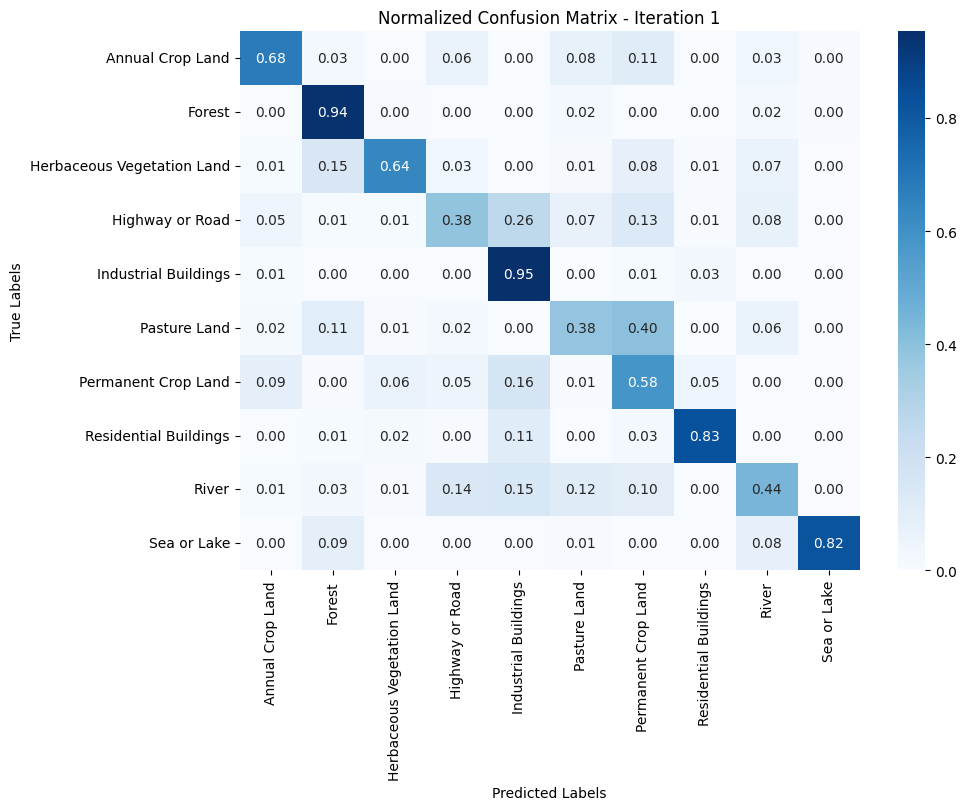

Test Accuracy for iteration 1: 68.22%

Iteration 2/15
Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.11s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.32s/it]


Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.50s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:16<00:00,  1.09s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 58.44. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.24
New best setting, beta: 0.10, alpha: 0.59; accuracy: 36.94
New best setting, beta: 0.10, alpha: 1.09; accuracy: 37.50
New best setting, beta: 0.10, alpha: 1.59; accuracy: 37.98
New best setting, beta: 0.10, alpha: 2.08; accuracy: 38.72
New best setting, beta: 0.10, alpha: 2.58; accuracy: 39.30
New best setting, beta: 0.10, alpha: 3.07; accuracy: 40.04
New best setting, beta: 0.10, alpha: 3.56; accuracy: 40.80
New best setting, beta: 0.10, alpha: 4.06; accuracy: 41.33
New best setting, beta: 0.10, alpha: 4.55; accuracy: 42.06
New best setting, beta: 0.10, alpha: 5.05; accuracy: 42.80
New best setting, beta: 0.10, alpha: 5.54; accuracy: 43.50
New best setting, beta: 0.10, alpha: 6.04; accuracy: 43.94
New best setting, beta: 0.10, alpha: 6.54; accuracy: 44.48
New best setting,

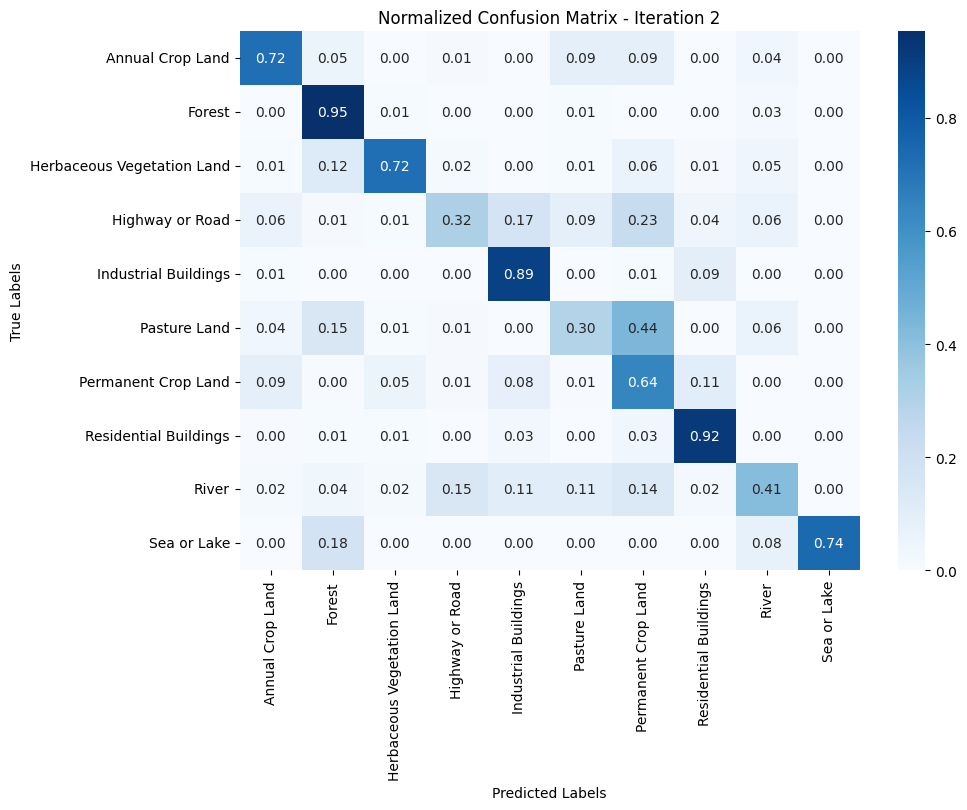

Test Accuracy for iteration 2: 68.09%

Iteration 3/15
Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.88s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.49s/it]


Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.28s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:15<00:00,  1.07s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 58.65. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.43
New best setting, beta: 0.10, alpha: 0.59; accuracy: 37.09
New best setting, beta: 0.10, alpha: 1.09; accuracy: 37.83
New best setting, beta: 0.10, alpha: 1.59; accuracy: 38.35
New best setting, beta: 0.10, alpha: 2.08; accuracy: 39.28
New best setting, beta: 0.10, alpha: 2.58; accuracy: 40.07
New best setting, beta: 0.10, alpha: 3.07; accuracy: 40.80
New best setting, beta: 0.10, alpha: 3.56; accuracy: 41.50
New best setting, beta: 0.10, alpha: 4.06; accuracy: 42.04
New best setting, beta: 0.10, alpha: 4.55; accuracy: 42.85
New best setting, beta: 0.10, alpha: 5.05; accuracy: 43.54
New best setting, beta: 0.10, alpha: 5.54; accuracy: 44.09
New best setting, beta: 0.10, alpha: 6.04; accuracy: 44.98
New best setting, beta: 0.10, alpha: 6.54; accuracy: 45.85
New best setting,

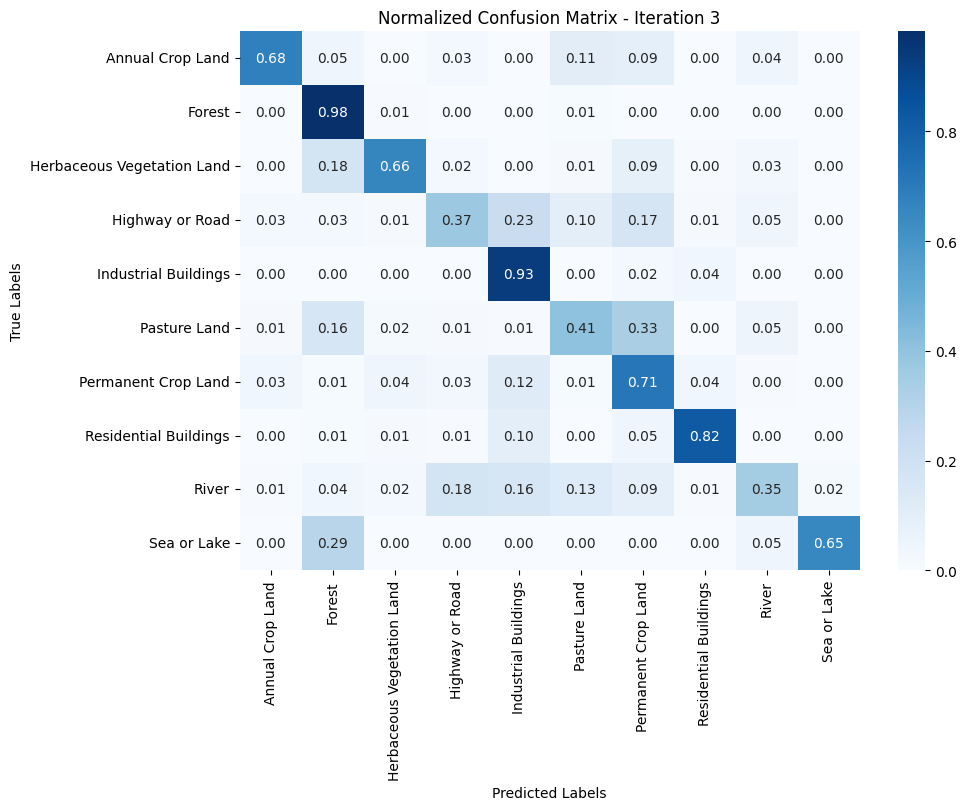

Test Accuracy for iteration 3: 67.19%

Iteration 4/15
Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.57s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.82s/it]


Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.75s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:25<00:00,  1.15s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 57.93. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.31
New best setting, beta: 0.10, alpha: 0.59; accuracy: 37.11
New best setting, beta: 0.10, alpha: 1.09; accuracy: 37.74
New best setting, beta: 0.10, alpha: 1.59; accuracy: 38.48
New best setting, beta: 0.10, alpha: 2.08; accuracy: 39.57
New best setting, beta: 0.10, alpha: 2.58; accuracy: 40.41
New best setting, beta: 0.10, alpha: 3.07; accuracy: 41.26
New best setting, beta: 0.10, alpha: 3.56; accuracy: 42.04
New best setting, beta: 0.10, alpha: 4.06; accuracy: 42.76
New best setting, beta: 0.10, alpha: 4.55; accuracy: 43.67
New best setting, beta: 0.10, alpha: 5.05; accuracy: 44.39
New best setting, beta: 0.10, alpha: 5.54; accuracy: 45.13
New best setting, beta: 0.10, alpha: 6.04; accuracy: 46.09
New best setting, beta: 0.10, alpha: 6.54; accuracy: 46.63
New best setting,

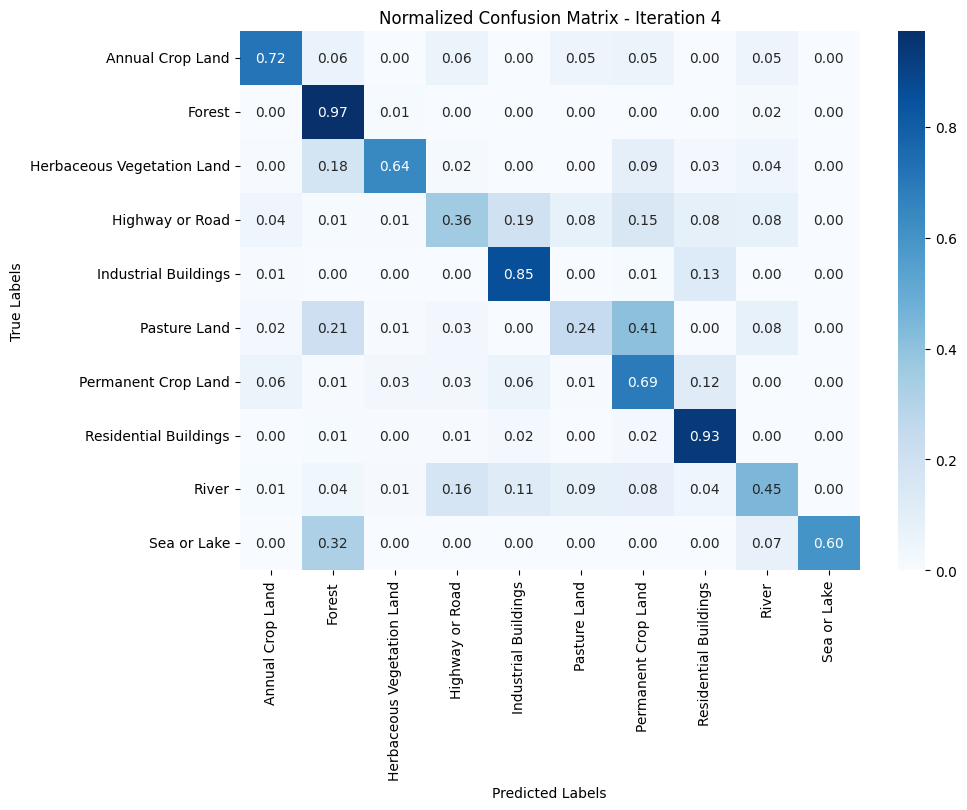

Test Accuracy for iteration 4: 66.43%

Iteration 5/15
Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.12s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.31s/it]


Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.65s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:19<00:00,  1.11s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 60.04. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.35
New best setting, beta: 0.10, alpha: 0.59; accuracy: 37.17
New best setting, beta: 0.10, alpha: 1.09; accuracy: 38.00
New best setting, beta: 0.10, alpha: 1.59; accuracy: 38.87
New best setting, beta: 0.10, alpha: 2.08; accuracy: 40.17
New best setting, beta: 0.10, alpha: 2.58; accuracy: 41.07
New best setting, beta: 0.10, alpha: 3.07; accuracy: 42.22
New best setting, beta: 0.10, alpha: 3.56; accuracy: 43.30
New best setting, beta: 0.10, alpha: 4.06; accuracy: 44.48
New best setting, beta: 0.10, alpha: 4.55; accuracy: 45.13
New best setting, beta: 0.10, alpha: 5.05; accuracy: 45.98
New best setting, beta: 0.10, alpha: 5.54; accuracy: 47.06
New best setting, beta: 0.10, alpha: 6.04; accuracy: 47.94
New best setting, beta: 0.10, alpha: 6.54; accuracy: 48.74
New best setting,

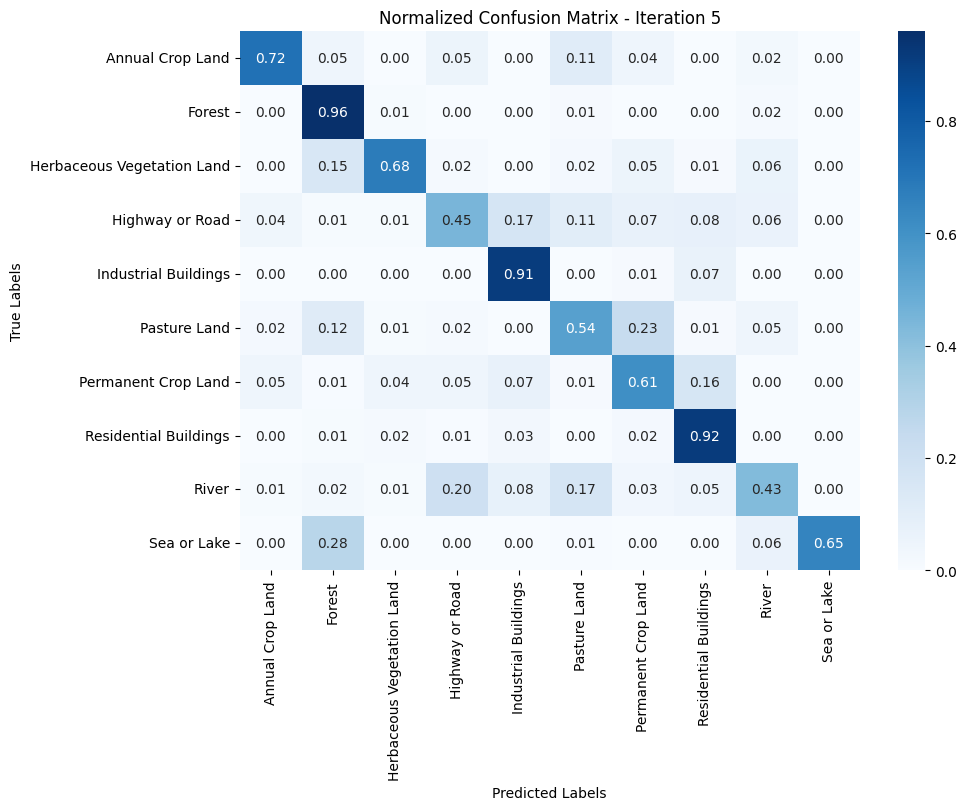

Test Accuracy for iteration 5: 69.85%

Iteration 6/15
Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.10s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.59s/it]


Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.87s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:13<00:00,  1.07s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 63.07. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.48
New best setting, beta: 0.10, alpha: 0.59; accuracy: 37.41
New best setting, beta: 0.10, alpha: 1.09; accuracy: 38.41
New best setting, beta: 0.10, alpha: 1.59; accuracy: 39.44
New best setting, beta: 0.10, alpha: 2.08; accuracy: 40.78
New best setting, beta: 0.10, alpha: 2.58; accuracy: 42.06
New best setting, beta: 0.10, alpha: 3.07; accuracy: 43.28
New best setting, beta: 0.10, alpha: 3.56; accuracy: 44.33
New best setting, beta: 0.10, alpha: 4.06; accuracy: 45.35
New best setting, beta: 0.10, alpha: 4.55; accuracy: 47.24
New best setting, beta: 0.10, alpha: 5.05; accuracy: 48.13
New best setting, beta: 0.10, alpha: 5.54; accuracy: 49.52
New best setting, beta: 0.10, alpha: 6.04; accuracy: 50.06
New best setting, beta: 0.10, alpha: 6.54; accuracy: 51.04
New best setting,

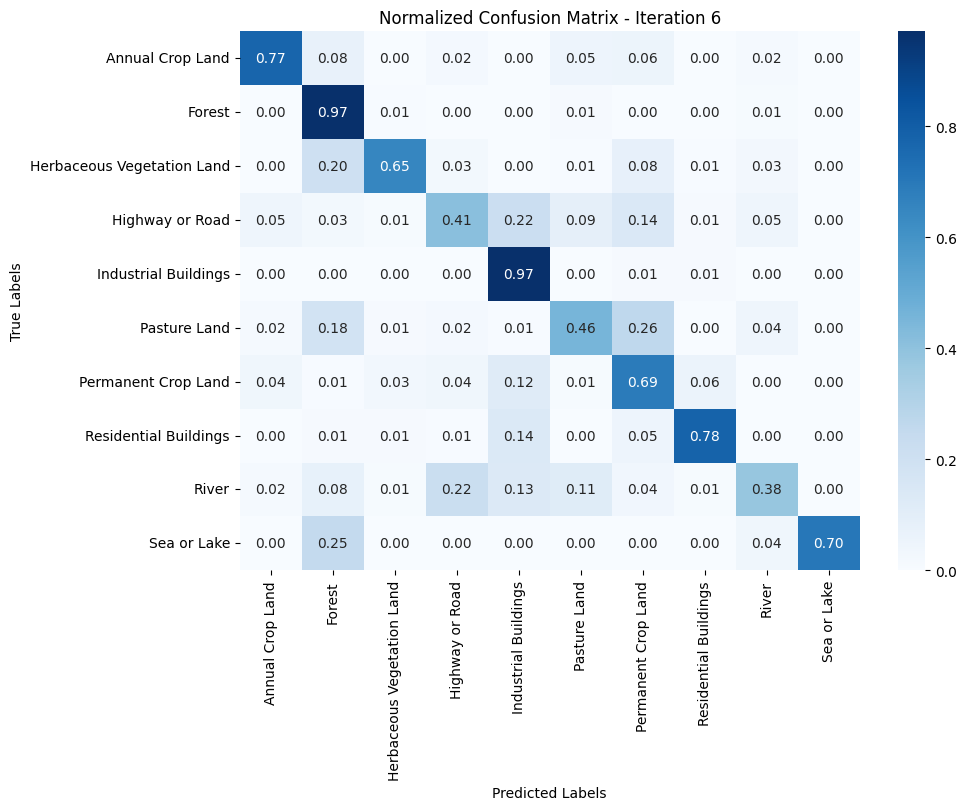

Test Accuracy for iteration 6: 69.16%

Iteration 7/15
Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.07s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.13s/it]


Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.04s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:24<00:00,  1.16s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 64.09. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.43
New best setting, beta: 0.10, alpha: 0.59; accuracy: 37.50
New best setting, beta: 0.10, alpha: 1.09; accuracy: 38.52
New best setting, beta: 0.10, alpha: 1.59; accuracy: 39.98
New best setting, beta: 0.10, alpha: 2.08; accuracy: 41.04
New best setting, beta: 0.10, alpha: 2.58; accuracy: 42.74
New best setting, beta: 0.10, alpha: 3.07; accuracy: 43.81
New best setting, beta: 0.10, alpha: 3.56; accuracy: 45.20
New best setting, beta: 0.10, alpha: 4.06; accuracy: 46.09
New best setting, beta: 0.10, alpha: 4.55; accuracy: 47.26
New best setting, beta: 0.10, alpha: 5.05; accuracy: 48.91
New best setting, beta: 0.10, alpha: 5.54; accuracy: 49.83
New best setting, beta: 0.10, alpha: 6.04; accuracy: 51.13
New best setting, beta: 0.10, alpha: 6.54; accuracy: 52.09
New best setting,

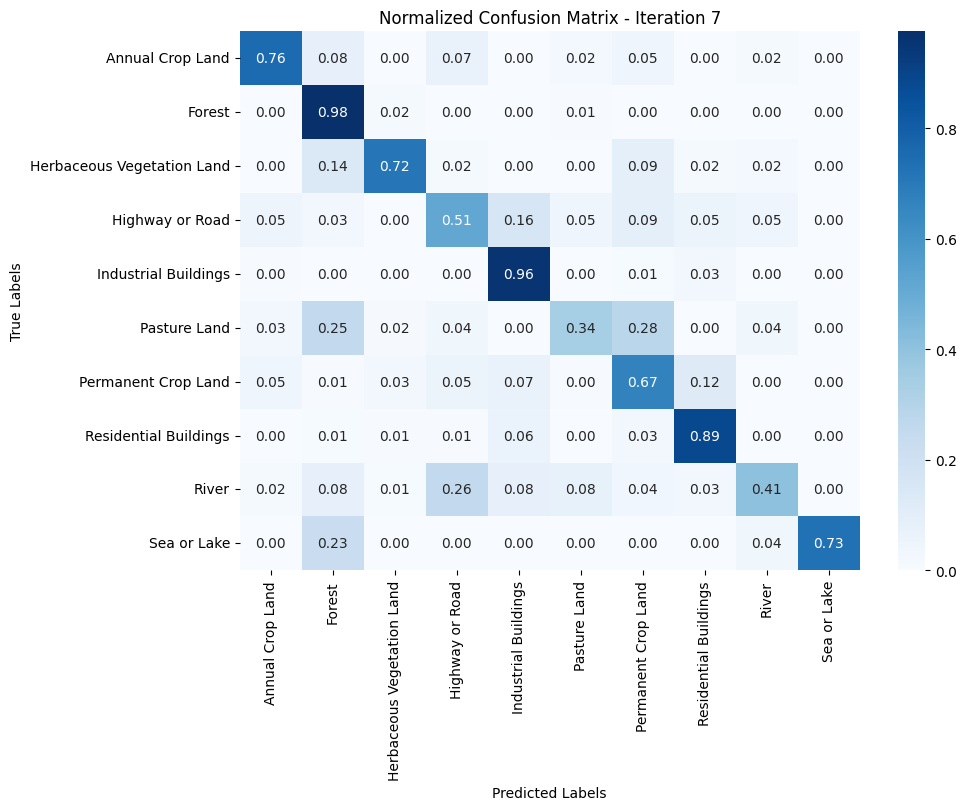

Test Accuracy for iteration 7: 71.23%

Iteration 8/15
Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.64s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.60s/it]


Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.65s/it]


Augment Epoch: 1 / 2


 99%|███████████████████████████████████████████████████████████████████████████████▎| 124/125 [02:24<00:00,  6.48it/s]

In [ ]:
for iteration in range(15):
    print(f"\nIteration {iteration + 1}/15")
    # 更新测试数据集
    filtered_test_data = [dataset.test[i] for i in remaining_test_indices]
    filtered_test_loader = build_data_loader(
        data_source=filtered_test_data,
        batch_size=64,
        is_train=False,
        tfm=preprocess,
        shuffle=False
    )

    # 运行 tip_adapter，获取logits和accuracy
    # tip_logits_test, tip_acc = run_tip_adapter(cfg, cache_keys, cache_values, val_features, val_labels, test_features, test_labels, clip_weights)

    # 应用Softmax来获取每个类别的概率
    tip_probabilities = torch.softmax(tip_logits_test, dim=1)
    # 提取出每一类中的概率最大的那个index
    max_probs, max_indices, topk_vectors = find_topk_prob_samples_by_class(tip_probabilities, k=2)
    # 将CUDA上的张量转移到CPU，并转换为Python列表
    max_indices_cpu = max_indices.cpu().tolist()
    
    
    # 假设 max_indices_cpu 是一个嵌套列表，例如 [[1, 2], [3, 4, 5]]
    flattened_indices = [index for sublist in max_indices_cpu for index in sublist]
    indices_set = set(flattened_indices)
    
    # 现在使用indices_set来过滤或选择数据
    subset_test_dataset = [dataset.test[i] for i in flattened_indices]
    
    #subset_test_dataset = [dataset.test[i] for i in max_indices_cpu]
    combined_data_source += subset_test_dataset
    remaining_test_indices.difference_update(indices_set)
    
    combined_train_loader_cache = build_data_loader(
            data_source=combined_data_source,
            batch_size=256, 
            tfm=train_tranform, 
            is_train=True, 
            shuffle=False
        )
    
    # 重构cache模型，这个是经过伪标签挑选和迭代以后的cache，重新生成了新的cache的特征和键值
    cache_keys, cache_values = build_cache_model(cfg, clip_model, combined_train_loader_cache)
    
    # 确保topk_vectors降维以匹配cache_values的维度，假设topk_vectors的形状为[1, 10, 10]
    # topk_vectors = topk_vectors.squeeze(0)  # 这将改变形状从[1, 10, 10]到[10, 10]
    # 确保topk_vectors有与combined_cache_values相同的维度
    topk_vectors = topk_vectors.view(-1, 10)  # 将topk_vectors调整为[2 * 10, 10]
    
    # 下面这两句是把softlabel变成hardlabel
    max_indices = torch.argmax(topk_vectors, dim=1)  # 输出形状为[N]
    # 创建一个新的张量用于存储硬标签
    hard_labels = torch.zeros_like(topk_vectors)
    
    # 使用 scatter_ 方法将最大索引处的值设置为1
    hard_labels.scatter_(1, max_indices.unsqueeze(1), 1.0)

    
    combined_cache_values = torch.cat((combined_cache_values, hard_labels), dim=0)
    
    
    
    # # 将CUDA上的张量转移到CPU，并转换为Python列表
    # max_indices_cpu = max_indices.cpu().tolist()

    # # 更新combined_data_source
    # max_indices_set = set(max_indices_cpu)
    #subset_test_dataset = [dataset.test[i] for i in max_indices_cpu]
    #combined_data_source += subset_test_dataset
    #remaining_test_indices.difference_update(max_indices_set)

    # combined_train_loader_cache = build_data_loader(
    #     data_source=combined_data_source,
    #     batch_size=256, 
    #     tfm=train_tranform, 
    #     is_train=True, 
    #     shuffle=False
    # )

    # 重构cache模型
    cache_keys, cache_values = build_cache_model(cfg, clip_model, combined_train_loader_cache)

    # 重新加载测试特征和标签(filtered_test_loader应该改为remaining_test_indices？)
    test_features, test_labels = pre_load_features(cfg, "test", clip_model, filtered_test_loader)

    # 再次运行tip_adapter以开始下一个迭代
    tip_logits_test, tip_acc = run_tip_adapter(cfg, cache_keys, combined_cache_values, val_features, val_labels, test_features, test_labels, clip_weights)
    
    # 调用绘图函数，绘制混淆矩阵
    tip_probabilities = torch.softmax(tip_logits_test, dim=1)
    tip_probabilities_np = tip_probabilities.detach().cpu().numpy()
    predicted_labels = np.argmax(tip_probabilities_np, axis=1)
    test_labels_np = test_labels.cpu().numpy()    
        
    plot_and_save_confusion_matrix(test_labels_np, predicted_labels, dataset.classnames, iteration, result_dir)
    
    test_accuracies.append(tip_acc)
    print(f"Test Accuracy for iteration {iteration + 1}: {tip_acc:.2f}%")

这是在8shot情况下，top2更新的hardlabel的结果，初始值是68.93

In [40]:
test_accuracies

[68.41975308641975,
 68.36633663366337,
 69.26889714993804,
 70.09937888198758,
 71.98356369069855,
 70.54050680314568,
 69.84107120510575,
 71.3371801304566,
 72.85301144222306,
 71.96520862221102,
 72.289613343442,
 71.97871801368127,
 72.44794311833418,
 72.36507128309572,
 72.0464404184741]

这是在4shot情况下，top2更新的hardlabel的结果，初始值是62.56

In [40]:
test_accuracies

[70.08641975308642,
 68.8490099009901,
 73.01685671789787,
 72.00546719681908,
 72.29696063776781,
 72.71478521478521,
 73.27575416197271,
 74.39146800501882,
 71.22202665325622,
 73.3366935483871,
 73.69617375931304,
 74.30379746835443,
 73.71225577264654,
 73.7377591250159,
 73.4225621414914]

这是在2shot的情况下，top5更新的hardlabel的结果（—初始值是59.41）

In [40]:
test_accuracies

[62.69135802469136,
 61.54037267080745,
 64.94460351051912,
 65.61443066516347,
 67.10343958674562,
 67.50348675034867,
 67.60581336053035,
 68.51353084519687,
 69.30718616952652,
 67.4192292720903,
 68.43684759916492,
 68.23730148313427,
 68.48356869473406,
 68.77407358214903,
 69.024064171123]

这是在2shot的情况下，top4更新的hardlabel的结果（—初始值是59.41）

In [40]:
test_accuracies

[61.18518518518518,
 60.9181141439206,
 63.691733996270976,
 65.95877576514678,
 63.477715003138734,
 67.83146209158572,
 69.08837327247369,
 68.59872611464968,
 70.57091653865848,
 72.60097761770002,
 71.50058162078325,
 69.51441184108023,
 70.16171100678143,
 69.86373165618448,
 70.19876266947479]

这是在2shot的情况下，top3更新的hardlabel的结果（—初始值是59.41）

In [40]:
test_accuracies

[61.839506172839506,
 61.36307311028501,
 62.973073582330315,
 65.53742682774941,
 66.8125,
 67.74557771923222,
 68.63510450768068,
 71.1324570273003,
 70.27266962587191,
 70.59946544482627,
 70.31928480204343,
 72.69580822971415,
 73.10513447432763,
 74.7773331612237,
 73.68489245918632]

这是在2shot的情况下，top2更新的hardlabel的结果（—初始值是59.41）

In [40]:
test_accuracies

[61.111111111111114,
 62.48762376237624,
 63.470828688219996,
 63.491866385198065,
 61.4340844018424,
 63.159865219019096,
 64.5439759789816,
 65.70926878213972,
 66.06312083490506,
 65.94833018273472,
 65.49589387239419,
 64.96137773838166,
 65.37192180756537,
 66.11528184247359,
 66.76872050006378]

这是在2shot的情况下，top1更新的hardlabel的结果（—初始值是59.41）

In [40]:
test_accuracies

[60.41975308641975,
 62.138442521631646,
 63.34528371863024,
 65.94875603416264,
 64.80426164519326,
 66.6459935499876,
 67.01440635866865,
 67.67375357453686,
 69.41366861695506,
 69.94889692135112,
 69.0752527143392,
 68.53216739537788,
 69.29714857428715,
 69.62072850168983,
 70.76074696077202]

这是在2shot的情况下，top2更新的hardlabel的结果（—初始值是59.41）

In [40]:
test_accuracies

[61.111111111111114,
 62.48762376237624,
 63.470828688219996,
 63.491866385198065,
 61.4340844018424,
 63.159865219019096,
 64.5439759789816,
 65.70926878213972,
 66.06312083490506,
 65.94833018273472,
 65.49589387239419,
 64.96137773838166,
 65.37192180756537,
 66.11528184247359,
 66.76872050006378]

下面这是2-shot在top1-5时的结果

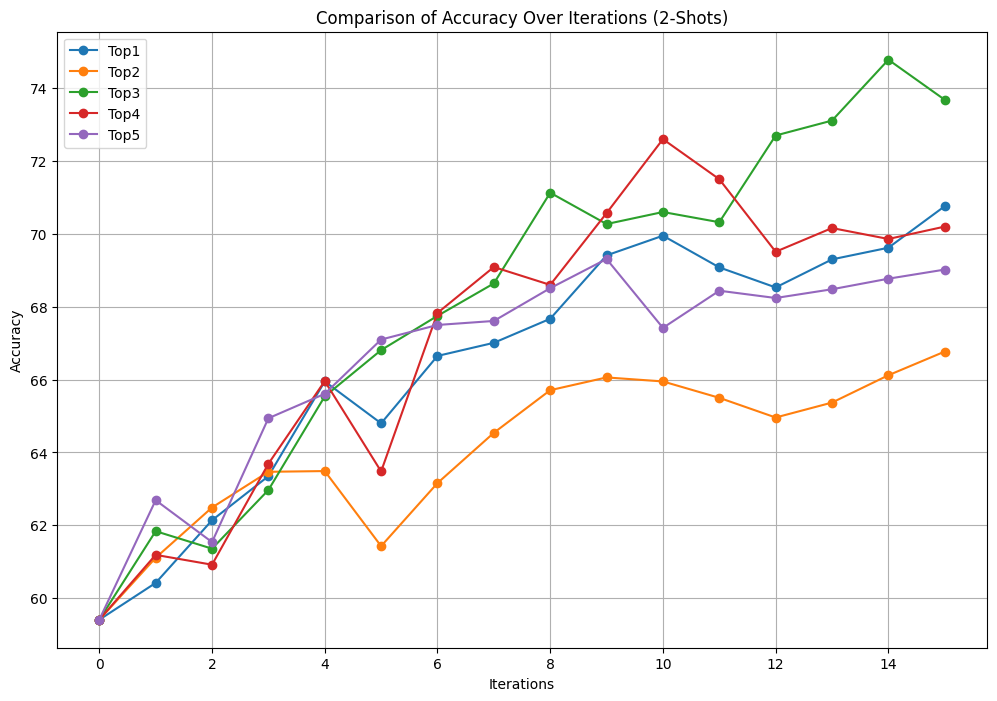

In [42]:
import matplotlib.pyplot as plt

# 不迭代时的精度
no_iteration_accuracy = 59.41

# 每次迭代的精度
top1 = [59.41, 60.42, 62.14, 63.35, 65.95, 64.80, 66.65, 67.01, 67.67, 69.41, 69.95, 69.08, 68.53, 69.30, 69.62, 70.76]
top2 = [59.41, 61.11, 62.49, 63.47, 63.49, 61.43, 63.16, 64.54, 65.71, 66.06, 65.95, 65.50, 64.96, 65.37, 66.12, 66.77]
top3 = [59.41, 61.84, 61.36, 62.97, 65.54, 66.81, 67.75, 68.64, 71.13, 70.27, 70.60, 70.32, 72.70, 73.11, 74.78, 73.68]
top4 = [59.41, 61.19, 60.92, 63.69, 65.96, 63.48, 67.83, 69.09, 68.60, 70.57, 72.60, 71.50, 69.51, 70.16, 69.86, 70.20]
top5 = [59.41, 62.69, 61.54, 64.94, 65.61, 67.10, 67.50, 67.61, 68.51, 69.31, 67.42, 68.44, 68.24, 68.48, 68.77, 69.02]

# 迭代次数，包括0次迭代
iterations = list(range(len(top1)))

# 绘图
plt.figure(figsize=(12, 8))

# 添加每次迭代的精度线
plt.plot(iterations, top1, marker='o', label='Top1')
plt.plot(iterations, top2, marker='o', label='Top2')
plt.plot(iterations, top3, marker='o', label='Top3')
plt.plot(iterations, top4, marker='o', label='Top4')
plt.plot(iterations, top5, marker='o', label='Top5')

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Over Iterations (2-Shots)')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_comparison_2_shots.png')  # 保存图像
plt.show()


In [42]:
test_accuracies

[61.111111111111114,
 62.48762376237624,
 63.470828688219996,
 63.491866385198065,
 61.4340844018424,
 63.159865219019096,
 64.5439759789816,
 65.70926878213972,
 66.06312083490506,
 65.94833018273472,
 65.49589387239419,
 64.96137773838166,
 65.37192180756537,
 66.11528184247359,
 66.76872050006378]

下面这是hardlabel中top2的数据

In [40]:
test_accuracies

[65.24691358024691,
 63.50247524752475,
 68.22291021671826,
 68.0943513345748,
 67.1933316745459,
 66.42554252930906,
 69.84623077884736,
 69.15653590675524,
 71.23115577889448,
 70.85642317380352,
 70.73232323232324,
 71.9746835443038,
 71.5391447785814,
 72.3769553605494,
 73.24751465715013]

下面这是hardlabel中top1的数据

In [40]:
test_accuracies

[61.111111111111114,
 62.48762376237624,
 63.470828688219996,
 63.491866385198065,
 61.4340844018424,
 63.159865219019096,
 64.5439759789816,
 65.70926878213972,
 66.06312083490506,
 65.94833018273472,
 65.49589387239419,
 64.96137773838166,
 65.37192180756537,
 66.11528184247359,
 66.76872050006378]

下面这是top5的数据

In [40]:
test_accuracies

[59.55555555555556,
 57.09316770186335,
 61.05577689243028,
 60.566203181761246,
 59.107525526282615,
 60.71020925808497,
 61.19688656373612,
 62.118100128369704,
 63.085861846352486,
 61.90105181145306,
 61.51534944480731,
 56.572554169402494,
 57.254125412541256,
 55.076310550763104,
 55.65345080763583]

下面这是top4的数据

In [40]:
test_accuracies

[58.839506172839506,
 59.46650124069479,
 62.03853325046613,
 61.474078700811994,
 59.977409638554214,
 61.084489281210594,
 62.87705956907478,
 61.227869061266084,
 61.914512413616585,
 61.91149987136609,
 61.70350264960579,
 60.24158981685933,
 60.71754729288976,
 62.157556691571635,
 61.3277133825079]

下面这是top3的数据

In [40]:
test_accuracies

[59.407407407407405,
 60.14869888475837,
 64.23873929767961,
 64.5285838834226,
 64.49556194524315,
 64.96863237139273,
 63.775959723096285,
 66.4687302590019,
 66.02434077079107,
 66.78544158819038,
 65.54675523760858,
 64.02923826622211,
 65.53854072834899,
 64.56987858434513,
 64.76536168006223]

下面这是top2的数据

In [40]:
test_accuracies

[62.08641975308642,
 61.67079207920792,
 64.00445765230312,
 66.84458788480636,
 63.76414976987188,
 68.74064837905237,
 67.35816045988503,
 67.66474567777499,
 67.9015446439784,
 68.52108244178729,
 66.73814328960646,
 66.5570868630674,
 68.42839036755386,
 65.93420551251111,
 65.36355532917356]

下面这是top1的数据

In [42]:
test_accuracies

[59.65389369592089,
 58.56613102595797,
 60.42079207920792,
 60.61656555651851,
 63.79075244824594,
 64.28837324730115,
 65.21306994657722,
 66.08208955223881,
 66.84931506849315,
 66.163819972572,
 66.98701947079381,
 68.61177058603023,
 66.82511883912935,
 68.39073262366938,
 68.15047021943573]

54.89 为不迭代的时候的预测精度，augment=2时。

下面是画出augment=2时，softlabel，topk=1时的折线图。

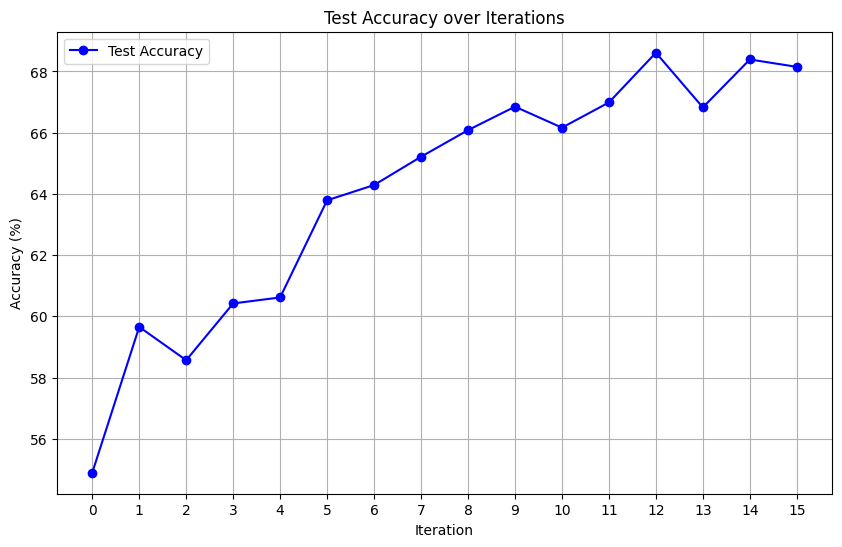

In [1]:
import matplotlib.pyplot as plt

# 不迭代时的初始值
initial_accuracy = 54.89

# 迭代后的准确率数据
test_accuracies = [
    59.65389369592089,
    58.56613102595797,
    60.42079207920792,
    60.61656555651851,
    63.79075244824594,
    64.28837324730115,
    65.21306994657722,
    66.08208955223881,
    66.84931506849315,
    66.163819972572,
    66.98701947079381,
    68.61177058603023,
    66.82511883912935,
    68.39073262366938,
    68.15047021943573
]

# 在列表的开头插入初始值
accuracies = [initial_accuracy] + test_accuracies

# 生成迭代次数，从0开始到15
iterations = list(range(len(accuracies)))

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(iterations, accuracies, marker='o', linestyle='-', color='b', label='Test Accuracy')

# 添加图表标题和标签
plt.title('Test Accuracy over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.xticks(iterations)
plt.grid(True)
plt.legend()

# 显示图表
plt.show()


下面这个程序中的数据是1shot情况下，softlabel的结果，从top1 到 top5 

FileNotFoundError: [Errno 2] No such file or directory: '\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\mnt\\data\\accuracy_over_iterations.png'

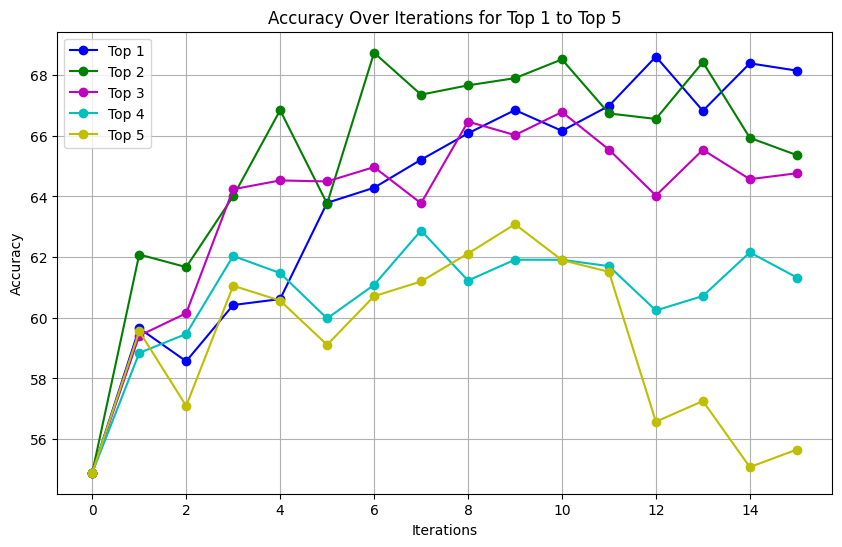

In [42]:
# Updating the code as per the user's request
import matplotlib.pyplot as plt
# Data
top1 = [59.65389369592089, 58.56613102595797, 60.42079207920792, 60.61656555651851, 63.79075244824594, 64.28837324730115, 65.21306994657722, 66.08208955223881, 66.84931506849315, 66.163819972572, 66.98701947079381, 68.61177058603023, 66.82511883912935, 68.39073262366938, 68.15047021943573]
top2 = [62.08641975308642, 61.67079207920792, 64.00445765230312, 66.84458788480636, 63.76414976987188, 68.74064837905237, 67.35816045988503, 67.66474567777499, 67.9015446439784, 68.52108244178729, 66.73814328960646, 66.5570868630674, 68.42839036755386, 65.93420551251111, 65.36355532917356]
top3 = [59.407407407407405, 60.14869888475837, 64.23873929767961, 64.5285838834226, 64.49556194524315, 64.96863237139273, 63.775959723096285, 66.4687302590019, 66.02434077079107, 66.78544158819038, 65.54675523760858, 64.02923826622211, 65.53854072834899, 64.56987858434513, 64.76536168006223]
top4 = [58.839506172839506, 59.46650124069479, 62.03853325046613, 61.474078700811994, 59.977409638554214, 61.084489281210594, 62.87705956907478, 61.227869061266084, 61.914512413616585, 61.91149987136609, 61.70350264960579, 60.24158981685933, 60.71754729288976, 62.157556691571635, 61.3277133825079]
top5 = [59.55555555555556, 57.09316770186335, 61.05577689243028, 60.566203181761246, 59.107525526282615, 60.71020925808497, 61.19688656373612, 62.118100128369704, 63.085861846352486, 61.90105181145306, 61.51534944480731, 56.572554169402494, 57.254125412541256, 55.076310550763104, 55.65345080763583]

# Add initial accuracy to the beginning of each list
initial_accuracy = 54.89
top1.insert(0, initial_accuracy)
top2.insert(0, initial_accuracy)
top3.insert(0, initial_accuracy)
top4.insert(0, initial_accuracy)
top5.insert(0, initial_accuracy)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(top1, marker='o', label='Top 1', color='b')
plt.plot(top2, marker='o', label='Top 2', color='g')
plt.plot(top3, marker='o', label='Top 3', color='m')
plt.plot(top4, marker='o', label='Top 4', color='c')
plt.plot(top5, marker='o', label='Top 5', color='y')

# Labels and Title
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Iterations for Top 1 to Top 5')
plt.legend()
plt.grid(True)

# Save plot
plt.savefig('/mnt/data/accuracy_over_iterations.png')

# Show plot
plt.show()


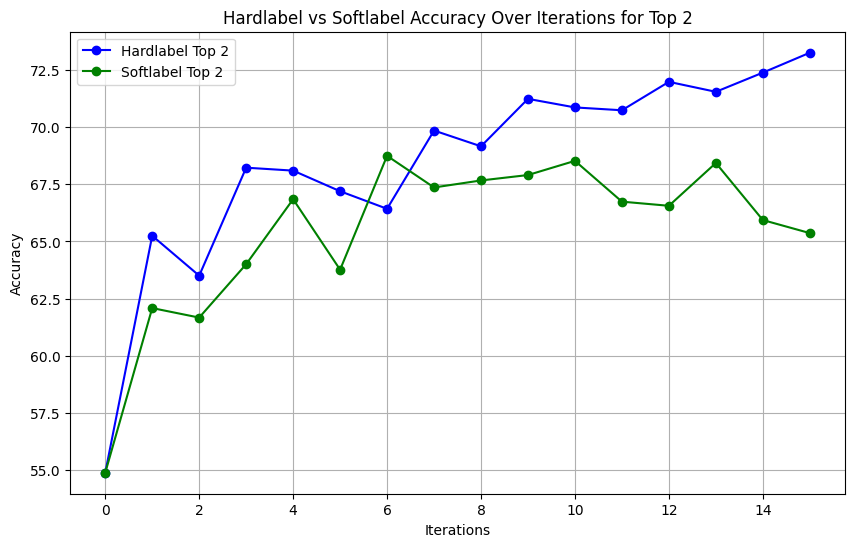

In [43]:
import matplotlib.pyplot as plt

# Hardlabel and softlabel data for top2
hardlabel_top2 = [
    65.24691358024691, 63.50247524752475, 68.22291021671826, 68.0943513345748, 
    67.1933316745459, 66.42554252930906, 69.84623077884736, 69.15653590675524, 
    71.23115577889448, 70.85642317380352, 70.73232323232324, 71.9746835443038, 
    71.5391447785814, 72.3769553605494, 73.24751465715013
]
softlabel_top2 = [
    62.08641975308642, 61.67079207920792, 64.00445765230312, 66.84458788480636, 
    63.76414976987188, 68.74064837905237, 67.35816045988503, 67.66474567777499, 
    67.9015446439784, 68.52108244178729, 66.73814328960646, 66.5570868630674, 
    68.42839036755386, 65.93420551251111, 65.36355532917356
]

# Adding initial accuracy for both hardlabel and softlabel
initial_accuracy = 54.89
hardlabel_top2.insert(0, initial_accuracy)
softlabel_top2.insert(0, initial_accuracy)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(hardlabel_top2, marker='o', label='Hardlabel Top 2', color='b')
plt.plot(softlabel_top2, marker='o', label='Softlabel Top 2', color='g')

# Labels and Title
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Hardlabel vs Softlabel Accuracy Over Iterations for Top 2')
plt.legend()
plt.grid(True)

# Save plot
plt.savefig('hardlabel_vs_softlabel_top2.png')

# Show plot
plt.show()


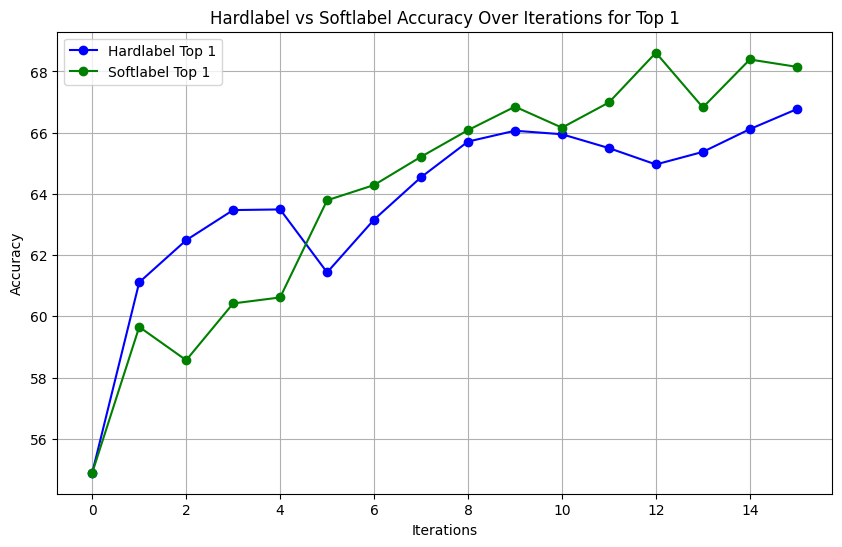

In [41]:
import matplotlib.pyplot as plt

# Hardlabel and softlabel data for top1
hardlabel_top1 = [
    61.111111111111114, 62.48762376237624, 63.470828688219996, 63.491866385198065, 
    61.4340844018424, 63.159865219019096, 64.5439759789816, 65.70926878213972, 
    66.06312083490506, 65.94833018273472, 65.49589387239419, 64.96137773838166, 
    65.37192180756537, 66.11528184247359, 66.76872050006378
]
softlabel_top1 = [
    59.65389369592089, 58.56613102595797, 60.42079207920792, 60.61656555651851, 
    63.79075244824594, 64.28837324730115, 65.21306994657722, 66.08208955223881, 
    66.84931506849315, 66.163819972572, 66.98701947079381, 68.61177058603023, 
    66.82511883912935, 68.39073262366938, 68.15047021943573
]

# Adding initial accuracy for both hardlabel and softlabel
initial_accuracy = 54.89
hardlabel_top1.insert(0, initial_accuracy)
softlabel_top1.insert(0, initial_accuracy)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(hardlabel_top1, marker='o', label='Hardlabel Top 1', color='b')
plt.plot(softlabel_top1, marker='o', label='Softlabel Top 1', color='g')

# Labels and Title
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Hardlabel vs Softlabel Accuracy Over Iterations for Top 1')
plt.legend()
plt.grid(True)

# Save plot
plt.savefig('hardlabel_vs_softlabel_top1.png')

# Show plot
plt.show()


In [38]:
combined_data_source

In [39]:
for item in combined_data_source:  
    print("Label:", item.label, "Domain:", item.domain, "Image Path:", item.impath)

Label: 0 Domain: -1 Image Path: eurosat\2750\AnnualCrop/AnnualCrop_2365.jpg
Label: 1 Domain: -1 Image Path: eurosat\2750\Forest/Forest_2046.jpg
Label: 2 Domain: -1 Image Path: eurosat\2750\HerbaceousVegetation/HerbaceousVegetation_503.jpg
Label: 3 Domain: -1 Image Path: eurosat\2750\Highway/Highway_125.jpg
Label: 4 Domain: -1 Image Path: eurosat\2750\Industrial/Industrial_2006.jpg
Label: 5 Domain: -1 Image Path: eurosat\2750\Pasture/Pasture_573.jpg
Label: 6 Domain: -1 Image Path: eurosat\2750\PermanentCrop/PermanentCrop_1476.jpg
Label: 7 Domain: -1 Image Path: eurosat\2750\Residential/Residential_1520.jpg
Label: 8 Domain: -1 Image Path: eurosat\2750\River/River_882.jpg
Label: 9 Domain: -1 Image Path: eurosat\2750\SeaLake/SeaLake_1624.jpg


In [40]:
filtered_test_data = [dataset.test[i] for i in remaining_test_indices]
filtered_test_loader = build_data_loader(
        data_source=filtered_test_data,
        batch_size=64,
        is_train=False,
        tfm=preprocess,
        shuffle=False
    )

In [41]:
# 应用Softmax来获取每个类别的概率
tip_probabilities = torch.softmax(tip_logits_test, dim=1)

下面这段代码是新的，目的是提取出索引对应的概率向量，就是soft-label，为以后的加入cachevalue做准备

In [42]:
import torch

def find_topk_prob_samples_by_class(probabilities, k=5):
    """
    返回每个类别中概率最高的k个样本的概率、索引以及对应的预测向量。
    Args:
        probabilities (Tensor): 一个形状为[N, C]的概率张量，其中N是样本数，C是类别数。
        k (int): 需要返回的TOP-k概率。

    Returns:
        Tuple[Tensor, Tensor, Tensor]: 三个张量，
            第一个是TOP-k概率，
            第二个是对应的索引，
            第三个是对应的预测向量。
    """
    # 使用topk来获取每一列（类别）的TOP-k概率和索引
    max_probs, max_indices = torch.topk(probabilities, k, dim=0)

    # 提取对应的预测向量
    # 这需要对每个类别的索引进行处理以抓取原始概率矩阵中对应的行
    topk_vectors = probabilities[:, None].expand(-1, probabilities.size(1), -1)[max_indices, torch.arange(probabilities.size(1))[None, :]]

    return max_probs, max_indices, topk_vectors

# 示例用法
# 假设 tip_probabilities 是一个已经通过softmax计算出的概率张量，形状为[N, C]
#tip_probabilities = torch.rand(100, 10)  # 假设有100个样本和10个类别
#max_probs, max_indices, topk_vectors = find_topk_prob_samples_by_class(tip_probabilities, k=5)

# print("Top-5 probabilities by class:", max_probs)
# print("Indices of samples with top-5 probabilities:", max_indices)
# print("Top-5 prediction vectors by class:", topk_vectors)



In [43]:
max_probs, max_indices, topk_vectors = find_topk_prob_samples_by_class(tip_probabilities, k=1)

In [44]:
print("Max probabilities by class:", max_probs)

Max probabilities by class: tensor([[0.9546, 0.9912, 0.9053, 0.9854, 0.9937, 0.8638, 0.9102, 0.9189, 0.9268,
         0.9868]], device='cuda:0', dtype=torch.float16)


In [45]:
print("Indices of samples with max probabilities:", max_indices)

Indices of samples with max probabilities: tensor([[ 833, 1324, 2506, 3171, 3645, 6889, 5467, 5566, 6973, 7681]],
       device='cuda:0')


In [46]:
print("Top-1 prediction vectors by class:", topk_vectors)

Top-1 prediction vectors by class: tensor([[[9.5459e-01, 2.9907e-03, 1.4124e-03, 8.6517e-03, 3.5167e-04,
          3.8414e-03, 2.5436e-02, 8.0490e-04, 1.4582e-03, 4.9591e-04],
         [2.5487e-04, 9.9121e-01, 1.2422e-04, 2.4567e-03, 5.9605e-05,
          2.6150e-03, 4.2701e-04, 5.9605e-05, 1.4906e-03, 1.2360e-03],
         [2.3155e-03, 4.1016e-02, 9.0527e-01, 1.1391e-02, 7.5150e-04,
          7.4730e-03, 6.2904e-03, 1.0767e-03, 2.0630e-02, 3.9368e-03],
         [4.4489e-04, 4.8561e-03, 2.0361e-04, 9.8535e-01, 2.4815e-03,
          1.8730e-03, 2.7256e-03, 1.5378e-04, 1.5526e-03, 2.4962e-04],
         [6.2644e-05, 1.2457e-04, 9.8526e-05, 7.5102e-04, 9.9365e-01,
          3.4034e-05, 7.9966e-04, 4.4594e-03, 1.1164e-04, 3.4034e-05],
         [1.4404e-02, 6.2561e-02, 3.3684e-03, 3.0975e-02, 1.3161e-04,
          8.6377e-01, 1.0704e-02, 1.6773e-04, 1.1757e-02, 2.3155e-03],
         [4.1901e-02, 3.8376e-03, 6.5269e-03, 1.1108e-02, 4.5586e-03,
          1.8021e-02, 9.1016e-01, 2.8076e-03, 7.5

In [47]:
# 将CUDA上的张量转移到CPU，并转换为Python列表
max_indices_cpu = max_indices.cpu().tolist()


# 假设 max_indices_cpu 是一个嵌套列表，例如 [[1, 2], [3, 4, 5]]
flattened_indices = [index for sublist in max_indices_cpu for index in sublist]
indices_set = set(flattened_indices)

# 现在使用indices_set来过滤或选择数据
subset_test_dataset = [dataset.test[i] for i in flattened_indices]

#subset_test_dataset = [dataset.test[i] for i in max_indices_cpu]
combined_data_source += subset_test_dataset
remaining_test_indices.difference_update(indices_set)


In [48]:
 combined_train_loader_cache = build_data_loader(
        data_source=combined_data_source,
        batch_size=256, 
        tfm=train_tranform, 
        is_train=True, 
        shuffle=False
    )

In [49]:
subset_test_dataset

In [50]:
for item in combined_data_source:  
    print("Label:", item.label, "Domain:", item.domain, "Image Path:", item.impath)

Label: 0 Domain: -1 Image Path: eurosat\2750\AnnualCrop/AnnualCrop_2365.jpg
Label: 1 Domain: -1 Image Path: eurosat\2750\Forest/Forest_2046.jpg
Label: 2 Domain: -1 Image Path: eurosat\2750\HerbaceousVegetation/HerbaceousVegetation_503.jpg
Label: 3 Domain: -1 Image Path: eurosat\2750\Highway/Highway_125.jpg
Label: 4 Domain: -1 Image Path: eurosat\2750\Industrial/Industrial_2006.jpg
Label: 5 Domain: -1 Image Path: eurosat\2750\Pasture/Pasture_573.jpg
Label: 6 Domain: -1 Image Path: eurosat\2750\PermanentCrop/PermanentCrop_1476.jpg
Label: 7 Domain: -1 Image Path: eurosat\2750\Residential/Residential_1520.jpg
Label: 8 Domain: -1 Image Path: eurosat\2750\River/River_882.jpg
Label: 9 Domain: -1 Image Path: eurosat\2750\SeaLake/SeaLake_1624.jpg
Label: 0 Domain: -1 Image Path: eurosat\2750\AnnualCrop/AnnualCrop_520.jpg
Label: 1 Domain: -1 Image Path: eurosat\2750\Forest/Forest_1852.jpg
Label: 2 Domain: -1 Image Path: eurosat\2750\HerbaceousVegetation/HerbaceousVegetation_560.jpg
Label: 3 Domai

In [51]:
combined_data_source

In [52]:
# 重构cache模型，这个是经过伪标签挑选和迭代以后的cache，重新生成了新的cache的特征和键值
cache_keys, cache_values = build_cache_model(cfg, clip_model, combined_train_loader_cache)

Augment Epoch: 0 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.63s/it]


Augment Epoch: 1 / 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.77s/it]


In [53]:
cache_keys.shape

torch.Size([1024, 20])

In [54]:
cache_values

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

这里有个重要的问题，就是首先cache中，人家本来就有的那一部分，先给人提取出来，然后再把后续迭代过程中，加进去的那些给cat到后面。

In [55]:
#这里还没有改变cachevalues，只是把之前初始化的值拿过来备用，在这个值的基础上，狗尾续貂。
combined_cache_values

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0',
       dtype=torch.float16)

下面这段代码就是在原来的基础上，把cache的value改了，改为softlabel标签。后面的程序就不变了，只是把cachevalue改为combinecahcevalue就行了

In [56]:
import torch

# 假设 cache_values 和 topk_vectors 已经定义并加载到同一个设备上（例如 CPU 或 CUDA）

# 示例数据
# cache_values = torch.eye(10)  # 假设是10x10的单位矩阵
# topk_vectors = ...  # topk_vectors 你之前获得的结果，形状应当是[1, 10, 10]，这里简化处理

# 确保topk_vectors降维以匹配cache_values的维度，假设topk_vectors的形状为[1, 10, 10]
topk_vectors = topk_vectors.squeeze(0)  # 这将改变形状从[1, 10, 10]到[10, 10]

combined_cache_values = torch.cat((combined_cache_values, topk_vectors), dim=0)

print(combined_cache_values)



tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000

In [57]:
 # 重新加载测试特征和标签(filtered_test_loader应该改为remaining_test_indices？)
test_features, test_labels = pre_load_features(cfg, "test", clip_model, filtered_test_loader)

# 再次运行tip_adapter以开始下一个迭代
tip_logits_test, tip_acc = run_tip_adapter(cfg, cache_keys, combined_cache_values, val_features, val_labels, test_features, test_labels, clip_weights)
test_accuracies.append(tip_acc)

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [01:46<00:00,  1.20it/s]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 38.17. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.13
New best setting, beta: 0.16, alpha: 0.10; accuracy: 36.15
New best setting, beta: 0.22, alpha: 0.10; accuracy: 36.19
New best setting, beta: 0.46, alpha: 0.10; accuracy: 36.20
New best setting, beta: 0.64, alpha: 0.59; accuracy: 36.28
New best setting, beta: 0.64, alpha: 1.09; accuracy: 36.48
New best setting, beta: 0.69, alpha: 1.09; accuracy: 36.59
New best setting, beta: 0.69, alpha: 2.08; accuracy: 36.67
New best setting, beta: 0.75, alpha: 1.09; accuracy: 36.83
New best setting, beta: 0.75, alpha: 1.59; accuracy: 36.85
New best setting, beta: 0.75, alpha: 2.08; accuracy: 37.00
New best setting, beta: 0.81, alpha: 1.59; accuracy: 37.22
New best setting, beta: 0.81, alpha: 2.08; accuracy: 37.24
New best setting, beta: 0.81, alpha: 2.58; accuracy: 37.26
New best setting,

In [58]:
test_accuracies

[58.39506172839506]


-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 58.28. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.35
New best setting, beta: 0.10, alpha: 0.59; accuracy: 36.89
New best setting, beta: 0.10, alpha: 1.09; accuracy: 37.50
New best setting, beta: 0.10, alpha: 1.59; accuracy: 37.89
New best setting, beta: 0.10, alpha: 2.08; accuracy: 38.56
New best setting, beta: 0.10, alpha: 2.58; accuracy: 39.00
New best setting, beta: 0.10, alpha: 3.07; accuracy: 39.44
New best setting, beta: 0.10, alpha: 3.56; accuracy: 40.04
New best setting, beta: 0.10, alpha: 4.06; accuracy: 40.80
New best setting, beta: 0.10, alpha: 4.55; accuracy: 41.57
New best setting, beta: 0.10, alpha: 5.05; accuracy: 41.78
New best setting, beta: 0.10, alpha: 5.54; accuracy: 42.91
New best setting, beta: 0.10, alpha: 6.04; accuracy: 43.33
New best setting, beta: 0.10, alpha: 6.54; accuracy: 44.19
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.83s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.57s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.69s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.74s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.30s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.30s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.35s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.50s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.11s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:41<00:00,  1.27s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 57.06. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.20
New best setting, beta: 0.10, alpha: 0.59; accuracy: 40.59
New best setting, beta: 0.10, alpha: 1.09; accuracy: 40.78
New best setting, beta: 0.16, alpha: 0.59; accuracy: 41.07
New best setting, beta: 0.16, alpha: 1.09; accuracy: 41.96
New best setting, beta: 0.22, alpha: 1.09; accuracy: 43.30
New best setting, beta: 0.28, alpha: 1.09; accuracy: 44.50
New best setting, beta: 0.34, alpha: 1.09; accuracy: 45.33
New best setting, beta: 0.40, alpha: 1.09; accuracy: 46.11
New best setting, beta: 0.40, alpha: 1.59; accuracy: 46.46
New best setting, beta: 0.46, alpha: 1.09; accuracy: 47.15
New best setting, beta: 0.46, alpha: 1.59; accuracy: 47.83
New best setting, beta: 0.52, alpha: 1.09; accuracy: 48.09
New best setting, beta: 0.52, alpha: 1.59; accuracy: 48.87
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:45<00:00, 45.31s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.81s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.99s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.73s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.96s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.71s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.54s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.55s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.60s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:45<00:00,  1.31s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 41.15. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.87
New best setting, beta: 0.10, alpha: 0.59; accuracy: 38.74
New best setting, beta: 0.16, alpha: 0.59; accuracy: 39.50
New best setting, beta: 0.22, alpha: 0.59; accuracy: 40.04
New best setting, beta: 0.28, alpha: 0.59; accuracy: 40.54
New best setting, beta: 0.34, alpha: 0.59; accuracy: 41.00
New best setting, beta: 0.40, alpha: 0.59; accuracy: 41.59
New best setting, beta: 0.46, alpha: 0.59; accuracy: 42.35
New best setting, beta: 0.52, alpha: 0.59; accuracy: 43.11
New best setting, beta: 0.58, alpha: 0.59; accuracy: 43.48
New best setting, beta: 0.64, alpha: 0.59; accuracy: 44.19
New best setting, beta: 0.69, alpha: 0.59; accuracy: 44.72
New best setting, beta: 0.75, alpha: 0.59; accuracy: 45.48
New best setting, beta: 0.81, alpha: 0.59; accuracy: 45.93
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:47<00:00, 47.62s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.66s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.34s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.93s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.41s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.26s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.57s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.63s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.13s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:43<00:00,  1.29s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 41.76. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 37.04
New best setting, beta: 0.10, alpha: 0.59; accuracy: 38.83
New best setting, beta: 0.16, alpha: 0.59; accuracy: 39.56
New best setting, beta: 0.22, alpha: 0.59; accuracy: 40.20
New best setting, beta: 0.28, alpha: 0.59; accuracy: 40.65
New best setting, beta: 0.34, alpha: 0.59; accuracy: 41.30
New best setting, beta: 0.40, alpha: 0.59; accuracy: 42.09
New best setting, beta: 0.46, alpha: 0.59; accuracy: 42.94
New best setting, beta: 0.52, alpha: 0.59; accuracy: 43.43
New best setting, beta: 0.58, alpha: 0.59; accuracy: 44.15
New best setting, beta: 0.64, alpha: 0.59; accuracy: 44.85
New best setting, beta: 0.69, alpha: 0.59; accuracy: 45.54
New best setting, beta: 0.75, alpha: 0.59; accuracy: 46.30
New best setting, beta: 0.81, alpha: 0.59; accuracy: 46.85
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:46<00:00, 46.13s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.29s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.04s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.07s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.36s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.79s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.46s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.32s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.21s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:42<00:00,  1.28s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 44.44. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 37.09
New best setting, beta: 0.10, alpha: 0.59; accuracy: 38.91
New best setting, beta: 0.16, alpha: 0.59; accuracy: 39.81
New best setting, beta: 0.22, alpha: 0.59; accuracy: 40.43
New best setting, beta: 0.28, alpha: 0.59; accuracy: 41.07
New best setting, beta: 0.34, alpha: 0.59; accuracy: 41.83
New best setting, beta: 0.40, alpha: 0.59; accuracy: 42.80
New best setting, beta: 0.46, alpha: 0.59; accuracy: 43.41
New best setting, beta: 0.52, alpha: 0.59; accuracy: 44.19
New best setting, beta: 0.58, alpha: 0.59; accuracy: 44.80
New best setting, beta: 0.64, alpha: 0.59; accuracy: 45.52
New best setting, beta: 0.69, alpha: 0.59; accuracy: 46.39
New best setting, beta: 0.75, alpha: 0.59; accuracy: 46.96
New best setting, beta: 0.81, alpha: 0.59; accuracy: 47.59
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:45<00:00, 45.02s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.52s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.16s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.95s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.87s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.48s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.38s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.41s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.46s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:40<00:00,  1.27s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 45.33. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 37.04
New best setting, beta: 0.10, alpha: 0.59; accuracy: 39.04
New best setting, beta: 0.16, alpha: 0.59; accuracy: 39.85
New best setting, beta: 0.22, alpha: 0.59; accuracy: 40.48
New best setting, beta: 0.28, alpha: 0.59; accuracy: 41.35
New best setting, beta: 0.34, alpha: 0.59; accuracy: 42.00
New best setting, beta: 0.40, alpha: 0.59; accuracy: 42.87
New best setting, beta: 0.46, alpha: 0.59; accuracy: 43.59
New best setting, beta: 0.52, alpha: 0.59; accuracy: 44.39
New best setting, beta: 0.58, alpha: 0.59; accuracy: 45.07
New best setting, beta: 0.64, alpha: 0.59; accuracy: 45.91
New best setting, beta: 0.69, alpha: 0.59; accuracy: 46.70
New best setting, beta: 0.75, alpha: 0.59; accuracy: 47.50
New best setting, beta: 0.81, alpha: 0.59; accuracy: 48.13
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.20s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.98s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.28s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.22s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.90s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.06s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.79s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.67s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.37s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:37<00:00,  1.25s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 38.72. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.30
New best setting, beta: 0.16, alpha: 0.10; accuracy: 36.59
New best setting, beta: 0.22, alpha: 0.10; accuracy: 36.67
New best setting, beta: 0.28, alpha: 0.10; accuracy: 36.87
New best setting, beta: 0.34, alpha: 0.10; accuracy: 37.04
New best setting, beta: 0.40, alpha: 0.10; accuracy: 37.11
New best setting, beta: 0.40, alpha: 0.59; accuracy: 37.26
New best setting, beta: 0.46, alpha: 0.59; accuracy: 37.81
New best setting, beta: 0.52, alpha: 0.59; accuracy: 38.30
New best setting, beta: 0.58, alpha: 0.59; accuracy: 38.85
New best setting, beta: 0.64, alpha: 0.59; accuracy: 39.33
New best setting, beta: 0.69, alpha: 0.59; accuracy: 39.76
New best setting, beta: 0.75, alpha: 0.59; accuracy: 40.00
New best setting, beta: 0.81, alpha: 0.59; accuracy: 40.54
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.54s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.82s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.31s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.48s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.48s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.14s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.37s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.14s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.77s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:38<00:00,  1.26s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 34.81. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 35.35
New best setting, beta: 0.16, alpha: 0.10; accuracy: 35.59
New best setting, beta: 0.22, alpha: 0.10; accuracy: 35.76
New best setting, beta: 0.28, alpha: 0.10; accuracy: 36.00
New best setting, beta: 0.34, alpha: 0.10; accuracy: 36.17
New best setting, beta: 0.40, alpha: 0.10; accuracy: 36.26
New best setting, beta: 0.46, alpha: 0.10; accuracy: 36.52
New best setting, beta: 0.52, alpha: 0.10; accuracy: 36.65
New best setting, beta: 0.58, alpha: 0.10; accuracy: 36.78
New best setting, beta: 0.64, alpha: 0.10; accuracy: 36.87
New best setting, beta: 0.69, alpha: 0.10; accuracy: 37.19
New best setting, beta: 0.75, alpha: 0.10; accuracy: 37.33
New best setting, beta: 0.81, alpha: 0.10; accuracy: 37.48
New best setting, beta: 0.87, alpha: 0.10; accuracy: 37.72
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:47<00:00, 47.13s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.36s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.24s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.39s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.29s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.49s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.57s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.06s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.33s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:44<00:00,  1.31s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 32.35. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 37.07
New best setting, beta: 0.16, alpha: 0.10; accuracy: 37.17
New best setting, beta: 0.22, alpha: 0.10; accuracy: 37.37
New best setting, beta: 0.28, alpha: 0.10; accuracy: 37.52
New best setting, beta: 0.34, alpha: 0.10; accuracy: 37.91
New best setting, beta: 0.40, alpha: 0.10; accuracy: 37.96
New best setting, beta: 0.46, alpha: 0.10; accuracy: 38.15
New best setting, beta: 0.52, alpha: 0.10; accuracy: 38.31
New best setting, beta: 0.52, alpha: 0.59; accuracy: 38.61
New best setting, beta: 0.58, alpha: 0.59; accuracy: 39.24
New best setting, beta: 0.64, alpha: 0.59; accuracy: 39.70
New best setting, beta: 0.69, alpha: 0.59; accuracy: 40.00
New best setting, beta: 0.75, alpha: 0.59; accuracy: 40.56
New best setting, beta: 0.81, alpha: 0.59; accuracy: 41.04
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:46<00:00, 46.81s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.76s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.84s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.66s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.61s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.45s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.72s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.46s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.59s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:44<00:00,  1.31s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 33.19. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 35.98
New best setting, beta: 0.16, alpha: 0.10; accuracy: 36.28
New best setting, beta: 0.22, alpha: 0.10; accuracy: 36.46
New best setting, beta: 0.28, alpha: 0.10; accuracy: 36.70
New best setting, beta: 0.34, alpha: 0.10; accuracy: 36.89
New best setting, beta: 0.40, alpha: 0.10; accuracy: 37.09
New best setting, beta: 0.46, alpha: 0.10; accuracy: 37.30
New best setting, beta: 0.52, alpha: 0.10; accuracy: 37.48
New best setting, beta: 0.58, alpha: 0.10; accuracy: 37.70
New best setting, beta: 0.64, alpha: 0.10; accuracy: 37.89
New best setting, beta: 0.69, alpha: 0.10; accuracy: 38.04
New best setting, beta: 0.75, alpha: 0.10; accuracy: 38.31
New best setting, beta: 0.81, alpha: 0.10; accuracy: 38.44
New best setting, beta: 0.87, alpha: 0.10; accuracy: 38.65
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:46<00:00, 46.82s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.55s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.62s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.74s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.11s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.08s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.65s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.10s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.28s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:42<00:00,  1.29s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 19.93. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 37.33
New best setting, beta: 0.16, alpha: 0.10; accuracy: 37.57
New best setting, beta: 0.22, alpha: 0.10; accuracy: 37.85
New best setting, beta: 0.28, alpha: 0.10; accuracy: 37.98
New best setting, beta: 0.34, alpha: 0.10; accuracy: 38.24
New best setting, beta: 0.40, alpha: 0.10; accuracy: 38.37
New best setting, beta: 0.46, alpha: 0.10; accuracy: 38.67
New best setting, beta: 0.52, alpha: 0.10; accuracy: 38.83
New best setting, beta: 0.58, alpha: 0.10; accuracy: 39.15
New best setting, beta: 0.64, alpha: 0.10; accuracy: 39.39
New best setting, beta: 0.69, alpha: 0.10; accuracy: 39.78
New best setting, beta: 0.75, alpha: 0.10; accuracy: 39.91
New best setting, beta: 0.81, alpha: 0.10; accuracy: 40.19
New best setting, beta: 0.87, alpha: 0.10; accuracy: 40.37
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:49<00:00, 49.87s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.16s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.08s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.63s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.94s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.40s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.66s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.47s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.67s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:43<00:00,  1.30s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 27.65. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 35.91
New best setting, beta: 0.16, alpha: 0.10; accuracy: 36.13
New best setting, beta: 0.22, alpha: 0.10; accuracy: 36.48
New best setting, beta: 0.28, alpha: 0.10; accuracy: 36.74
New best setting, beta: 0.34, alpha: 0.10; accuracy: 36.81
New best setting, beta: 0.40, alpha: 0.10; accuracy: 37.11
New best setting, beta: 0.46, alpha: 0.10; accuracy: 37.33
New best setting, beta: 0.52, alpha: 0.10; accuracy: 37.54
New best setting, beta: 0.58, alpha: 0.10; accuracy: 37.81
New best setting, beta: 0.64, alpha: 0.10; accuracy: 38.07
New best setting, beta: 0.69, alpha: 0.10; accuracy: 38.52
New best setting, beta: 0.75, alpha: 0.10; accuracy: 38.70
New best setting, beta: 0.81, alpha: 0.10; accuracy: 38.93
New best setting, beta: 0.87, alpha: 0.10; accuracy: 39.11
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:48<00:00, 48.90s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.06s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.62s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.43s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.58s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.89s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.53s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.11s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.78s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:39<00:00,  1.27s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 18.41. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 35.98
New best setting, beta: 0.16, alpha: 0.10; accuracy: 36.44
New best setting, beta: 0.22, alpha: 0.10; accuracy: 36.74
New best setting, beta: 0.28, alpha: 0.10; accuracy: 36.98
New best setting, beta: 0.34, alpha: 0.10; accuracy: 37.19
New best setting, beta: 0.40, alpha: 0.10; accuracy: 37.37
New best setting, beta: 0.46, alpha: 0.10; accuracy: 37.56
New best setting, beta: 0.52, alpha: 0.10; accuracy: 37.85
New best setting, beta: 0.58, alpha: 0.10; accuracy: 38.09
New best setting, beta: 0.64, alpha: 0.10; accuracy: 38.35
New best setting, beta: 0.69, alpha: 0.10; accuracy: 38.69
New best setting, beta: 0.75, alpha: 0.10; accuracy: 38.89
New best setting, beta: 0.81, alpha: 0.10; accuracy: 39.06
New best setting, beta: 0.87, alpha: 0.10; accuracy: 39.33
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.98s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.82s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.58s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.21s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.73s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.43s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.86s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:45<00:00, 45.30s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.33s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:45<00:00,  1.33s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 11.85. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.61
New best setting, beta: 0.16, alpha: 0.10; accuracy: 36.89
New best setting, beta: 0.22, alpha: 0.10; accuracy: 37.09
New best setting, beta: 0.28, alpha: 0.10; accuracy: 37.43
New best setting, beta: 0.34, alpha: 0.10; accuracy: 37.74
New best setting, beta: 0.40, alpha: 0.10; accuracy: 37.94
New best setting, beta: 0.46, alpha: 0.10; accuracy: 38.15
New best setting, beta: 0.52, alpha: 0.10; accuracy: 38.59
New best setting, beta: 0.58, alpha: 0.10; accuracy: 38.87
New best setting, beta: 0.64, alpha: 0.10; accuracy: 39.02
New best setting, beta: 0.69, alpha: 0.10; accuracy: 39.33
New best setting, beta: 0.75, alpha: 0.10; accuracy: 39.63
New best setting, beta: 0.81, alpha: 0.10; accuracy: 39.83
New best setting, beta: 0.87, alpha: 0.10; accuracy: 40.19
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:49<00:00, 49.58s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.80s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.06s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.46s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.56s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.76s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.75s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.78s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.79s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 13.09. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.94
New best setting, beta: 0.16, alpha: 0.10; accuracy: 37.39
New best setting, beta: 0.22, alpha: 0.10; accuracy: 37.83
New best setting, beta: 0.28, alpha: 0.10; accuracy: 38.02
New best setting, beta: 0.34, alpha: 0.10; accuracy: 38.39
New best setting, beta: 0.40, alpha: 0.10; accuracy: 38.59
New best setting, beta: 0.46, alpha: 0.10; accuracy: 38.98
New best setting, beta: 0.52, alpha: 0.10; accuracy: 39.37
New best setting, beta: 0.58, alpha: 0.10; accuracy: 39.70
New best setting, beta: 0.64, alpha: 0.10; accuracy: 39.91
New best setting, beta: 0.69, alpha: 0.10; accuracy: 40.17
New best setting, beta: 0.75, alpha: 0.10; accuracy: 40.43
New best setting, beta: 0.81, alpha: 0.10; accuracy: 40.72
New best setting, beta: 0.87, alpha: 0.10; accuracy: 40.98
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:50<00:00, 50.97s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.60s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.45s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.90s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.79s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.50s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.21s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.38s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.75s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 13.72. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.89
New best setting, beta: 0.16, alpha: 0.10; accuracy: 37.20
New best setting, beta: 0.22, alpha: 0.10; accuracy: 37.59
New best setting, beta: 0.28, alpha: 0.10; accuracy: 37.81
New best setting, beta: 0.34, alpha: 0.10; accuracy: 38.07
New best setting, beta: 0.40, alpha: 0.10; accuracy: 38.50
New best setting, beta: 0.46, alpha: 0.10; accuracy: 38.81
New best setting, beta: 0.52, alpha: 0.10; accuracy: 39.22
New best setting, beta: 0.58, alpha: 0.10; accuracy: 39.50
New best setting, beta: 0.64, alpha: 0.10; accuracy: 39.74
New best setting, beta: 0.69, alpha: 0.10; accuracy: 40.00
New best setting, beta: 0.75, alpha: 0.10; accuracy: 40.33
New best setting, beta: 0.81, alpha: 0.10; accuracy: 40.67
New best setting, beta: 0.87, alpha: 0.10; accuracy: 40.81
New best setting,

Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3\\envs\\tipadapter\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'>
Traceback (most recent call last):
  File "u:\Anaconda3\envs\tipadapter\lib\site-packages\matplotlib\backends\backend_agg.py", line 234, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=get_hinting_flag())
OSError: [Errno 22] Invalid argument
Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3\\envs\\tipadapter\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'>
Traceback (most recent call last):
  File "u:\Anaconda3\envs\tipadapter\lib\site-packages\matplotlib\backends\backend_agg.py", line 234, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=get_hinting_flag())
OSError: [Errno 22] Invalid argument
Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3

New best setting, beta: 11.76, alpha: 1.59; accuracy: 66.83
New best setting, beta: 11.76, alpha: 2.08; accuracy: 66.93
New best setting, beta: 11.82, alpha: 2.08; accuracy: 66.96
New best setting, beta: 11.88, alpha: 2.08; accuracy: 67.07
New best setting, beta: 11.94, alpha: 4.06; accuracy: 67.09
New best setting, beta: 11.94, alpha: 4.55; accuracy: 67.11

After searching, the best accuarcy: 67.11.


-------- Evaluating on the test set. --------

**** Zero-shot CLIP's test accuracy: 36.12. ****

**** Tip-Adapter's test accuracy: 68.07. ****

Test Accuracy for iteration 15: 68.07%


Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3\\envs\\tipadapter\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'>
Traceback (most recent call last):
  File "u:\Anaconda3\envs\tipadapter\lib\site-packages\matplotlib\backends\backend_agg.py", line 234, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=get_hinting_flag())
OSError: [Errno 22] Invalid argument
Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3\\envs\\tipadapter\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'>
Traceback (most recent call last):
  File "u:\Anaconda3\envs\tipadapter\lib\site-packages\matplotlib\backends\backend_agg.py", line 234, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=get_hinting_flag())
OSError: [Errno 22] Invalid argument
Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3

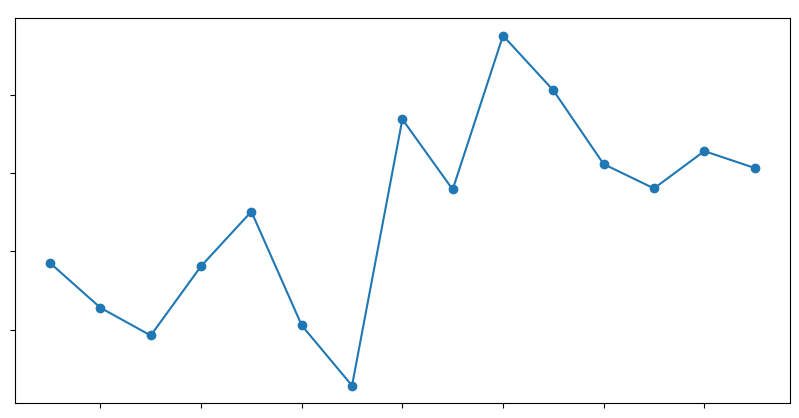

In [293]:
import matplotlib.pyplot as plt

# 初始化存储每次迭代的测试准确率的列表
test_accuracies = []

# 初始训练数据和测试数据
combined_data_source = list(dataset.train_x)  # 起始时只包含原始训练数据
remaining_test_indices = set(range(len(dataset.test)))  # 初始包含所有测试数据的索引

# 运行 tip_adapter，获取logits和accuracy
tip_logits_test, tip_acc = run_tip_adapter(cfg, cache_keys, cache_values, val_features, val_labels, test_features, test_labels, clip_weights)

for iteration in range(15):
    print(f"\nIteration {iteration + 1}/15")
    # 更新测试数据集
    filtered_test_data = [dataset.test[i] for i in remaining_test_indices]
    filtered_test_loader = build_data_loader(
        data_source=filtered_test_data,
        batch_size=64,
        is_train=False,
        tfm=preprocess,
        shuffle=False
    )

    # 运行 tip_adapter，获取logits和accuracy
    # tip_logits_test, tip_acc = run_tip_adapter(cfg, cache_keys, cache_values, val_features, val_labels, test_features, test_labels, clip_weights)

    # 应用Softmax来获取每个类别的概率
    tip_probabilities = torch.softmax(tip_logits_test, dim=1)
    # 提取出每一类中的概率最大的那个index
    max_probs, max_indices = find_max_prob_samples_by_class(tip_probabilities)
    print("Max probabilities by class:", max_probs)
    print("Indices of samples with max probabilities:", max_indices)

    # 将CUDA上的张量转移到CPU，并转换为Python列表
    max_indices_cpu = max_indices.cpu().tolist()

    # 更新combined_data_source
    max_indices_set = set(max_indices_cpu)
    subset_test_dataset = [dataset.test[i] for i in max_indices_cpu]
    combined_data_source += subset_test_dataset
    remaining_test_indices.difference_update(max_indices_set)

    combined_train_loader_cache = build_data_loader(
        data_source=combined_data_source,
        batch_size=256, 
        tfm=train_tranform, 
        is_train=True, 
        shuffle=False
    )

    # 重构cache模型
    cache_keys, cache_values = build_cache_model(cfg, clip_model, combined_train_loader_cache)

    # 重新加载测试特征和标签(filtered_test_loader应该改为remaining_test_indices？)
    test_features, test_labels = pre_load_features(cfg, "test", clip_model, filtered_test_loader)

    # 再次运行tip_adapter以开始下一个迭代
    tip_logits_test, tip_acc = run_tip_adapter(cfg, cache_keys, cache_values, val_features, val_labels, test_features, test_labels, clip_weights)
    test_accuracies.append(tip_acc)
    print(f"Test Accuracy for iteration {iteration + 1}: {tip_acc:.2f}%")

# 绘制测试准确率的折线图
plt.figure(figsize=(10, 5))
plt.plot(range(1, 16), test_accuracies, marker='o')
plt.title('Test Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Test Accuracy (%)')

plt.show()


In [249]:
 # 重新加载测试特征和标签(filtered_test_loader应该改为remaining_test_indices？)
test_features, test_labels = pre_load_features(cfg, "test", clip_model, filtered_test_loader)

# 再次运行tip_adapter以开始下一个迭代
tip_logits_test, tip_acc = run_tip_adapter(cfg, cache_keys, combined_cache_values, val_features, val_labels, test_features, test_labels, clip_weights)
test_accuracies.append(tip_acc)

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:53<00:00,  1.37s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 38.17. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.13
New best setting, beta: 0.16, alpha: 0.10; accuracy: 36.15
New best setting, beta: 0.22, alpha: 0.10; accuracy: 36.19
New best setting, beta: 0.46, alpha: 0.10; accuracy: 36.20
New best setting, beta: 0.64, alpha: 0.59; accuracy: 36.28
New best setting, beta: 0.64, alpha: 1.09; accuracy: 36.48
New best setting, beta: 0.69, alpha: 1.09; accuracy: 36.59
New best setting, beta: 0.69, alpha: 2.08; accuracy: 36.67
New best setting, beta: 0.75, alpha: 1.09; accuracy: 36.83
New best setting, beta: 0.75, alpha: 1.59; accuracy: 36.85
New best setting, beta: 0.75, alpha: 2.08; accuracy: 37.00
New best setting, beta: 0.81, alpha: 1.59; accuracy: 37.22
New best setting, beta: 0.81, alpha: 2.08; accuracy: 37.24
New best setting, beta: 0.81, alpha: 2.58; accuracy: 37.26
New best setting,

In [250]:
#这个是硬标签，上一个是软标签，运行完了以后，对比一下结果。
# 重新加载测试特征和标签(filtered_test_loader应该改为remaining_test_indices？)
test_features, test_labels = pre_load_features(cfg, "test", clip_model, filtered_test_loader)

# 再次运行tip_adapter以开始下一个迭代
tip_logits_test, tip_acc = run_tip_adapter(cfg, cache_keys, cache_values, val_features, val_labels, test_features, test_labels, clip_weights)
test_accuracies.append(tip_acc)

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [03:00<00:00,  1.42s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 36.28. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.11
New best setting, beta: 0.10, alpha: 0.59; accuracy: 36.43
New best setting, beta: 0.16, alpha: 0.59; accuracy: 36.52
New best setting, beta: 0.16, alpha: 1.09; accuracy: 36.65
New best setting, beta: 0.22, alpha: 0.59; accuracy: 36.67
New best setting, beta: 0.22, alpha: 1.09; accuracy: 36.89
New best setting, beta: 0.28, alpha: 1.09; accuracy: 37.11
New best setting, beta: 0.34, alpha: 1.09; accuracy: 37.37
New best setting, beta: 0.40, alpha: 1.09; accuracy: 37.54
New best setting, beta: 0.46, alpha: 1.09; accuracy: 37.70
New best setting, beta: 0.52, alpha: 1.09; accuracy: 37.85
New best setting, beta: 0.58, alpha: 1.09; accuracy: 37.89
New best setting, beta: 0.64, alpha: 1.09; accuracy: 38.11
New best setting, beta: 0.69, alpha: 1.09; accuracy: 38.43
New best setting,

In [ ]:
# 将CUDA上的张量转移到CPU，并转换为Python列表
max_indices_cpu = max_indices.cpu().tolist()

# 更新combined_data_source
max_indices_set = set(max_indices_cpu)
subset_test_dataset = [dataset.test[i] for i in max_indices_cpu]
combined_data_source += subset_test_dataset
remaining_test_indices.difference_update(max_indices_set)

combined_train_loader_cache = build_data_loader(
    data_source=combined_data_source,
    batch_size=256, 
    tfm=train_tranform, 
    is_train=True, 
    shuffle=False
)

# 重构cache模型
cache_keys, cache_values = build_cache_model(cfg, clip_model, combined_train_loader_cache)

In [47]:
max_probs, max_indices, topk_vectors = find_topk_prob_samples_by_class(tip_probabilities, k=1)

In [48]:
print("Max probabilities by class:", max_probs)


Max probabilities by class: tensor([[0.9546, 0.9912, 0.9053, 0.9854, 0.9937, 0.8638, 0.9102, 0.9189, 0.9268,
         0.9868]], device='cuda:0', dtype=torch.float16)


In [49]:
print("Indices of samples with max probabilities:", max_indices)

Indices of samples with max probabilities: tensor([[ 833, 1324, 2506, 3171, 3645, 6889, 5467, 5566, 6973, 7681]],
       device='cuda:0')


In [50]:
print("Top-15 prediction vectors by class:", topk_vectors)

Top-15 prediction vectors by class: tensor([[0.9546, 0.9912, 0.9053, 0.9854, 0.9937, 0.8638, 0.9102, 0.9189, 0.9268,
         0.9868]], device='cuda:0', dtype=torch.float16)


In [ ]:
import torch

# 假设 cache_values 是您给出的张量，topk_vectors 是您计算出的张量
# 确保 topk_vectors 在最后一维之前的所有维度与 cache_values 相同

# 这里举一个具体的例子：
# 假设 topk_vectors 的形状是 [10, C]，其中 C 可能与 cache_values 的列数不同
# topk_vectors = some_function_that_generates_topk_vectors(...)

# 使用 torch.cat 连接两个张量
concatenated = torch.cat((cache_values, topk_vectors), dim=1)

# 输出新的张量以查看结果
print(concatenated)



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 58.28. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.35
New best setting, beta: 0.10, alpha: 0.59; accuracy: 36.89
New best setting, beta: 0.10, alpha: 1.09; accuracy: 37.50
New best setting, beta: 0.10, alpha: 1.59; accuracy: 37.89
New best setting, beta: 0.10, alpha: 2.08; accuracy: 38.56
New best setting, beta: 0.10, alpha: 2.58; accuracy: 39.00
New best setting, beta: 0.10, alpha: 3.07; accuracy: 39.44
New best setting, beta: 0.10, alpha: 3.56; accuracy: 40.04
New best setting, beta: 0.10, alpha: 4.06; accuracy: 40.80
New best setting, beta: 0.10, alpha: 4.55; accuracy: 41.57
New best setting, beta: 0.10, alpha: 5.05; accuracy: 41.78
New best setting, beta: 0.10, alpha: 5.54; accuracy: 42.91
New best setting, beta: 0.10, alpha: 6.04; accuracy: 43.33
New best setting, beta: 0.10, alpha: 6.54; accuracy: 44.19
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.83s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.57s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.69s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.74s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.30s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.30s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.35s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.50s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.11s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:41<00:00,  1.27s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 57.06. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.20
New best setting, beta: 0.10, alpha: 0.59; accuracy: 40.59
New best setting, beta: 0.10, alpha: 1.09; accuracy: 40.78
New best setting, beta: 0.16, alpha: 0.59; accuracy: 41.07
New best setting, beta: 0.16, alpha: 1.09; accuracy: 41.96
New best setting, beta: 0.22, alpha: 1.09; accuracy: 43.30
New best setting, beta: 0.28, alpha: 1.09; accuracy: 44.50
New best setting, beta: 0.34, alpha: 1.09; accuracy: 45.33
New best setting, beta: 0.40, alpha: 1.09; accuracy: 46.11
New best setting, beta: 0.40, alpha: 1.59; accuracy: 46.46
New best setting, beta: 0.46, alpha: 1.09; accuracy: 47.15
New best setting, beta: 0.46, alpha: 1.59; accuracy: 47.83
New best setting, beta: 0.52, alpha: 1.09; accuracy: 48.09
New best setting, beta: 0.52, alpha: 1.59; accuracy: 48.87
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:45<00:00, 45.31s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.81s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.99s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.73s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.96s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.71s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.54s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.55s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.60s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:45<00:00,  1.31s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 41.15. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.87
New best setting, beta: 0.10, alpha: 0.59; accuracy: 38.74
New best setting, beta: 0.16, alpha: 0.59; accuracy: 39.50
New best setting, beta: 0.22, alpha: 0.59; accuracy: 40.04
New best setting, beta: 0.28, alpha: 0.59; accuracy: 40.54
New best setting, beta: 0.34, alpha: 0.59; accuracy: 41.00
New best setting, beta: 0.40, alpha: 0.59; accuracy: 41.59
New best setting, beta: 0.46, alpha: 0.59; accuracy: 42.35
New best setting, beta: 0.52, alpha: 0.59; accuracy: 43.11
New best setting, beta: 0.58, alpha: 0.59; accuracy: 43.48
New best setting, beta: 0.64, alpha: 0.59; accuracy: 44.19
New best setting, beta: 0.69, alpha: 0.59; accuracy: 44.72
New best setting, beta: 0.75, alpha: 0.59; accuracy: 45.48
New best setting, beta: 0.81, alpha: 0.59; accuracy: 45.93
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:47<00:00, 47.62s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.66s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.34s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.93s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.41s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.26s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.57s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.63s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.13s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:43<00:00,  1.29s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 41.76. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 37.04
New best setting, beta: 0.10, alpha: 0.59; accuracy: 38.83
New best setting, beta: 0.16, alpha: 0.59; accuracy: 39.56
New best setting, beta: 0.22, alpha: 0.59; accuracy: 40.20
New best setting, beta: 0.28, alpha: 0.59; accuracy: 40.65
New best setting, beta: 0.34, alpha: 0.59; accuracy: 41.30
New best setting, beta: 0.40, alpha: 0.59; accuracy: 42.09
New best setting, beta: 0.46, alpha: 0.59; accuracy: 42.94
New best setting, beta: 0.52, alpha: 0.59; accuracy: 43.43
New best setting, beta: 0.58, alpha: 0.59; accuracy: 44.15
New best setting, beta: 0.64, alpha: 0.59; accuracy: 44.85
New best setting, beta: 0.69, alpha: 0.59; accuracy: 45.54
New best setting, beta: 0.75, alpha: 0.59; accuracy: 46.30
New best setting, beta: 0.81, alpha: 0.59; accuracy: 46.85
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:46<00:00, 46.13s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.29s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.04s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.07s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.36s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.79s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.46s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.32s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.21s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:42<00:00,  1.28s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 44.44. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 37.09
New best setting, beta: 0.10, alpha: 0.59; accuracy: 38.91
New best setting, beta: 0.16, alpha: 0.59; accuracy: 39.81
New best setting, beta: 0.22, alpha: 0.59; accuracy: 40.43
New best setting, beta: 0.28, alpha: 0.59; accuracy: 41.07
New best setting, beta: 0.34, alpha: 0.59; accuracy: 41.83
New best setting, beta: 0.40, alpha: 0.59; accuracy: 42.80
New best setting, beta: 0.46, alpha: 0.59; accuracy: 43.41
New best setting, beta: 0.52, alpha: 0.59; accuracy: 44.19
New best setting, beta: 0.58, alpha: 0.59; accuracy: 44.80
New best setting, beta: 0.64, alpha: 0.59; accuracy: 45.52
New best setting, beta: 0.69, alpha: 0.59; accuracy: 46.39
New best setting, beta: 0.75, alpha: 0.59; accuracy: 46.96
New best setting, beta: 0.81, alpha: 0.59; accuracy: 47.59
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:45<00:00, 45.02s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.52s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.16s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.95s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.87s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.48s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.38s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.41s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.46s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:40<00:00,  1.27s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 45.33. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 37.04
New best setting, beta: 0.10, alpha: 0.59; accuracy: 39.04
New best setting, beta: 0.16, alpha: 0.59; accuracy: 39.85
New best setting, beta: 0.22, alpha: 0.59; accuracy: 40.48
New best setting, beta: 0.28, alpha: 0.59; accuracy: 41.35
New best setting, beta: 0.34, alpha: 0.59; accuracy: 42.00
New best setting, beta: 0.40, alpha: 0.59; accuracy: 42.87
New best setting, beta: 0.46, alpha: 0.59; accuracy: 43.59
New best setting, beta: 0.52, alpha: 0.59; accuracy: 44.39
New best setting, beta: 0.58, alpha: 0.59; accuracy: 45.07
New best setting, beta: 0.64, alpha: 0.59; accuracy: 45.91
New best setting, beta: 0.69, alpha: 0.59; accuracy: 46.70
New best setting, beta: 0.75, alpha: 0.59; accuracy: 47.50
New best setting, beta: 0.81, alpha: 0.59; accuracy: 48.13
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.20s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.98s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.28s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.22s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.90s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.06s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.79s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.67s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.37s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:37<00:00,  1.25s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 38.72. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.30
New best setting, beta: 0.16, alpha: 0.10; accuracy: 36.59
New best setting, beta: 0.22, alpha: 0.10; accuracy: 36.67
New best setting, beta: 0.28, alpha: 0.10; accuracy: 36.87
New best setting, beta: 0.34, alpha: 0.10; accuracy: 37.04
New best setting, beta: 0.40, alpha: 0.10; accuracy: 37.11
New best setting, beta: 0.40, alpha: 0.59; accuracy: 37.26
New best setting, beta: 0.46, alpha: 0.59; accuracy: 37.81
New best setting, beta: 0.52, alpha: 0.59; accuracy: 38.30
New best setting, beta: 0.58, alpha: 0.59; accuracy: 38.85
New best setting, beta: 0.64, alpha: 0.59; accuracy: 39.33
New best setting, beta: 0.69, alpha: 0.59; accuracy: 39.76
New best setting, beta: 0.75, alpha: 0.59; accuracy: 40.00
New best setting, beta: 0.81, alpha: 0.59; accuracy: 40.54
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.54s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.82s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.31s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.48s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.48s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.14s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.37s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.14s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.77s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:38<00:00,  1.26s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 34.81. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 35.35
New best setting, beta: 0.16, alpha: 0.10; accuracy: 35.59
New best setting, beta: 0.22, alpha: 0.10; accuracy: 35.76
New best setting, beta: 0.28, alpha: 0.10; accuracy: 36.00
New best setting, beta: 0.34, alpha: 0.10; accuracy: 36.17
New best setting, beta: 0.40, alpha: 0.10; accuracy: 36.26
New best setting, beta: 0.46, alpha: 0.10; accuracy: 36.52
New best setting, beta: 0.52, alpha: 0.10; accuracy: 36.65
New best setting, beta: 0.58, alpha: 0.10; accuracy: 36.78
New best setting, beta: 0.64, alpha: 0.10; accuracy: 36.87
New best setting, beta: 0.69, alpha: 0.10; accuracy: 37.19
New best setting, beta: 0.75, alpha: 0.10; accuracy: 37.33
New best setting, beta: 0.81, alpha: 0.10; accuracy: 37.48
New best setting, beta: 0.87, alpha: 0.10; accuracy: 37.72
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:47<00:00, 47.13s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.36s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.24s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.39s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.29s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.49s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.57s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.06s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.33s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:44<00:00,  1.31s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 32.35. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 37.07
New best setting, beta: 0.16, alpha: 0.10; accuracy: 37.17
New best setting, beta: 0.22, alpha: 0.10; accuracy: 37.37
New best setting, beta: 0.28, alpha: 0.10; accuracy: 37.52
New best setting, beta: 0.34, alpha: 0.10; accuracy: 37.91
New best setting, beta: 0.40, alpha: 0.10; accuracy: 37.96
New best setting, beta: 0.46, alpha: 0.10; accuracy: 38.15
New best setting, beta: 0.52, alpha: 0.10; accuracy: 38.31
New best setting, beta: 0.52, alpha: 0.59; accuracy: 38.61
New best setting, beta: 0.58, alpha: 0.59; accuracy: 39.24
New best setting, beta: 0.64, alpha: 0.59; accuracy: 39.70
New best setting, beta: 0.69, alpha: 0.59; accuracy: 40.00
New best setting, beta: 0.75, alpha: 0.59; accuracy: 40.56
New best setting, beta: 0.81, alpha: 0.59; accuracy: 41.04
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:46<00:00, 46.81s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.76s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.84s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.66s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.61s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.45s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.72s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.46s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.59s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:44<00:00,  1.31s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 33.19. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 35.98
New best setting, beta: 0.16, alpha: 0.10; accuracy: 36.28
New best setting, beta: 0.22, alpha: 0.10; accuracy: 36.46
New best setting, beta: 0.28, alpha: 0.10; accuracy: 36.70
New best setting, beta: 0.34, alpha: 0.10; accuracy: 36.89
New best setting, beta: 0.40, alpha: 0.10; accuracy: 37.09
New best setting, beta: 0.46, alpha: 0.10; accuracy: 37.30
New best setting, beta: 0.52, alpha: 0.10; accuracy: 37.48
New best setting, beta: 0.58, alpha: 0.10; accuracy: 37.70
New best setting, beta: 0.64, alpha: 0.10; accuracy: 37.89
New best setting, beta: 0.69, alpha: 0.10; accuracy: 38.04
New best setting, beta: 0.75, alpha: 0.10; accuracy: 38.31
New best setting, beta: 0.81, alpha: 0.10; accuracy: 38.44
New best setting, beta: 0.87, alpha: 0.10; accuracy: 38.65
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:46<00:00, 46.82s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.55s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.62s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.74s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.11s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.08s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.65s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.10s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.28s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:42<00:00,  1.29s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 19.93. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 37.33
New best setting, beta: 0.16, alpha: 0.10; accuracy: 37.57
New best setting, beta: 0.22, alpha: 0.10; accuracy: 37.85
New best setting, beta: 0.28, alpha: 0.10; accuracy: 37.98
New best setting, beta: 0.34, alpha: 0.10; accuracy: 38.24
New best setting, beta: 0.40, alpha: 0.10; accuracy: 38.37
New best setting, beta: 0.46, alpha: 0.10; accuracy: 38.67
New best setting, beta: 0.52, alpha: 0.10; accuracy: 38.83
New best setting, beta: 0.58, alpha: 0.10; accuracy: 39.15
New best setting, beta: 0.64, alpha: 0.10; accuracy: 39.39
New best setting, beta: 0.69, alpha: 0.10; accuracy: 39.78
New best setting, beta: 0.75, alpha: 0.10; accuracy: 39.91
New best setting, beta: 0.81, alpha: 0.10; accuracy: 40.19
New best setting, beta: 0.87, alpha: 0.10; accuracy: 40.37
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:49<00:00, 49.87s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.16s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.08s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.63s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.94s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.40s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.66s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.47s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.67s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:43<00:00,  1.30s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 27.65. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 35.91
New best setting, beta: 0.16, alpha: 0.10; accuracy: 36.13
New best setting, beta: 0.22, alpha: 0.10; accuracy: 36.48
New best setting, beta: 0.28, alpha: 0.10; accuracy: 36.74
New best setting, beta: 0.34, alpha: 0.10; accuracy: 36.81
New best setting, beta: 0.40, alpha: 0.10; accuracy: 37.11
New best setting, beta: 0.46, alpha: 0.10; accuracy: 37.33
New best setting, beta: 0.52, alpha: 0.10; accuracy: 37.54
New best setting, beta: 0.58, alpha: 0.10; accuracy: 37.81
New best setting, beta: 0.64, alpha: 0.10; accuracy: 38.07
New best setting, beta: 0.69, alpha: 0.10; accuracy: 38.52
New best setting, beta: 0.75, alpha: 0.10; accuracy: 38.70
New best setting, beta: 0.81, alpha: 0.10; accuracy: 38.93
New best setting, beta: 0.87, alpha: 0.10; accuracy: 39.11
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:48<00:00, 48.90s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.06s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.62s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.43s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.58s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.89s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.53s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.11s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.78s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [02:39<00:00,  1.27s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 18.41. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 35.98
New best setting, beta: 0.16, alpha: 0.10; accuracy: 36.44
New best setting, beta: 0.22, alpha: 0.10; accuracy: 36.74
New best setting, beta: 0.28, alpha: 0.10; accuracy: 36.98
New best setting, beta: 0.34, alpha: 0.10; accuracy: 37.19
New best setting, beta: 0.40, alpha: 0.10; accuracy: 37.37
New best setting, beta: 0.46, alpha: 0.10; accuracy: 37.56
New best setting, beta: 0.52, alpha: 0.10; accuracy: 37.85
New best setting, beta: 0.58, alpha: 0.10; accuracy: 38.09
New best setting, beta: 0.64, alpha: 0.10; accuracy: 38.35
New best setting, beta: 0.69, alpha: 0.10; accuracy: 38.69
New best setting, beta: 0.75, alpha: 0.10; accuracy: 38.89
New best setting, beta: 0.81, alpha: 0.10; accuracy: 39.06
New best setting, beta: 0.87, alpha: 0.10; accuracy: 39.33
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.98s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.82s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.58s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.21s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.73s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.43s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.86s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:45<00:00, 45.30s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.33s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:45<00:00,  1.33s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 11.85. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.61
New best setting, beta: 0.16, alpha: 0.10; accuracy: 36.89
New best setting, beta: 0.22, alpha: 0.10; accuracy: 37.09
New best setting, beta: 0.28, alpha: 0.10; accuracy: 37.43
New best setting, beta: 0.34, alpha: 0.10; accuracy: 37.74
New best setting, beta: 0.40, alpha: 0.10; accuracy: 37.94
New best setting, beta: 0.46, alpha: 0.10; accuracy: 38.15
New best setting, beta: 0.52, alpha: 0.10; accuracy: 38.59
New best setting, beta: 0.58, alpha: 0.10; accuracy: 38.87
New best setting, beta: 0.64, alpha: 0.10; accuracy: 39.02
New best setting, beta: 0.69, alpha: 0.10; accuracy: 39.33
New best setting, beta: 0.75, alpha: 0.10; accuracy: 39.63
New best setting, beta: 0.81, alpha: 0.10; accuracy: 39.83
New best setting, beta: 0.87, alpha: 0.10; accuracy: 40.19
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:49<00:00, 49.58s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.80s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.06s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.46s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.56s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.76s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.75s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.78s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.79s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 13.09. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.94
New best setting, beta: 0.16, alpha: 0.10; accuracy: 37.39
New best setting, beta: 0.22, alpha: 0.10; accuracy: 37.83
New best setting, beta: 0.28, alpha: 0.10; accuracy: 38.02
New best setting, beta: 0.34, alpha: 0.10; accuracy: 38.39
New best setting, beta: 0.40, alpha: 0.10; accuracy: 38.59
New best setting, beta: 0.46, alpha: 0.10; accuracy: 38.98
New best setting, beta: 0.52, alpha: 0.10; accuracy: 39.37
New best setting, beta: 0.58, alpha: 0.10; accuracy: 39.70
New best setting, beta: 0.64, alpha: 0.10; accuracy: 39.91
New best setting, beta: 0.69, alpha: 0.10; accuracy: 40.17
New best setting, beta: 0.75, alpha: 0.10; accuracy: 40.43
New best setting, beta: 0.81, alpha: 0.10; accuracy: 40.72
New best setting, beta: 0.87, alpha: 0.10; accuracy: 40.98
New best setting,

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:50<00:00, 50.97s/it]


Augment Epoch: 1 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.60s/it]


Augment Epoch: 2 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.45s/it]


Augment Epoch: 3 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.90s/it]


Augment Epoch: 4 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.79s/it]


Augment Epoch: 5 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.50s/it]


Augment Epoch: 6 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.21s/it]


Augment Epoch: 7 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.38s/it]


Augment Epoch: 8 / 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.75s/it]


Augment Epoch: 9 / 10


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]



-------- Searching hyperparameters on the val set. --------

**** Zero-shot CLIP's val accuracy: 36.13. ****

**** Tip-Adapter's val accuracy: 13.72. ****

New best setting, beta: 0.10, alpha: 0.10; accuracy: 36.89
New best setting, beta: 0.16, alpha: 0.10; accuracy: 37.20
New best setting, beta: 0.22, alpha: 0.10; accuracy: 37.59
New best setting, beta: 0.28, alpha: 0.10; accuracy: 37.81
New best setting, beta: 0.34, alpha: 0.10; accuracy: 38.07
New best setting, beta: 0.40, alpha: 0.10; accuracy: 38.50
New best setting, beta: 0.46, alpha: 0.10; accuracy: 38.81
New best setting, beta: 0.52, alpha: 0.10; accuracy: 39.22
New best setting, beta: 0.58, alpha: 0.10; accuracy: 39.50
New best setting, beta: 0.64, alpha: 0.10; accuracy: 39.74
New best setting, beta: 0.69, alpha: 0.10; accuracy: 40.00
New best setting, beta: 0.75, alpha: 0.10; accuracy: 40.33
New best setting, beta: 0.81, alpha: 0.10; accuracy: 40.67
New best setting, beta: 0.87, alpha: 0.10; accuracy: 40.81
New best setting,

Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3\\envs\\tipadapter\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'>
Traceback (most recent call last):
  File "u:\Anaconda3\envs\tipadapter\lib\site-packages\matplotlib\backends\backend_agg.py", line 234, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=get_hinting_flag())
OSError: [Errno 22] Invalid argument
Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3\\envs\\tipadapter\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'>
Traceback (most recent call last):
  File "u:\Anaconda3\envs\tipadapter\lib\site-packages\matplotlib\backends\backend_agg.py", line 234, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=get_hinting_flag())
OSError: [Errno 22] Invalid argument
Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3

New best setting, beta: 11.76, alpha: 1.59; accuracy: 66.83
New best setting, beta: 11.76, alpha: 2.08; accuracy: 66.93
New best setting, beta: 11.82, alpha: 2.08; accuracy: 66.96
New best setting, beta: 11.88, alpha: 2.08; accuracy: 67.07
New best setting, beta: 11.94, alpha: 4.06; accuracy: 67.09
New best setting, beta: 11.94, alpha: 4.55; accuracy: 67.11

After searching, the best accuarcy: 67.11.


-------- Evaluating on the test set. --------

**** Zero-shot CLIP's test accuracy: 36.12. ****

**** Tip-Adapter's test accuracy: 68.07. ****

Test Accuracy for iteration 15: 68.07%


Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3\\envs\\tipadapter\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'>
Traceback (most recent call last):
  File "u:\Anaconda3\envs\tipadapter\lib\site-packages\matplotlib\backends\backend_agg.py", line 234, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=get_hinting_flag())
OSError: [Errno 22] Invalid argument
Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3\\envs\\tipadapter\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'>
Traceback (most recent call last):
  File "u:\Anaconda3\envs\tipadapter\lib\site-packages\matplotlib\backends\backend_agg.py", line 234, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=get_hinting_flag())
OSError: [Errno 22] Invalid argument
Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3

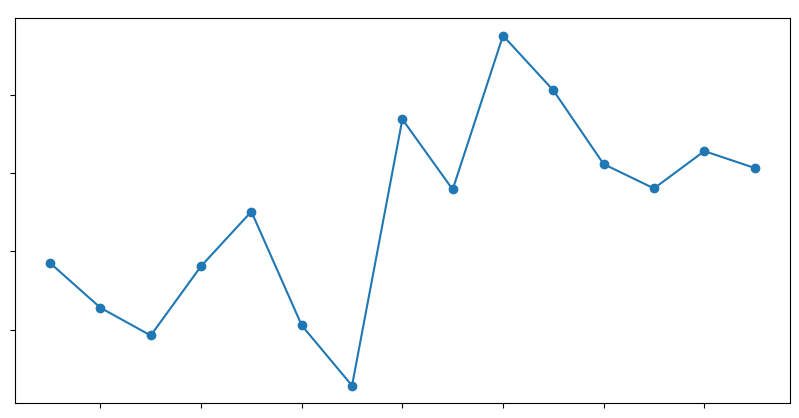

In [293]:
import matplotlib.pyplot as plt

# 初始化存储每次迭代的测试准确率的列表
test_accuracies = []

# 初始训练数据和测试数据
combined_data_source = list(dataset.train_x)  # 起始时只包含原始训练数据
remaining_test_indices = set(range(len(dataset.test)))  # 初始包含所有测试数据的索引

# 运行 tip_adapter，获取logits和accuracy
tip_logits_test, tip_acc = run_tip_adapter(cfg, cache_keys, cache_values, val_features, val_labels, test_features, test_labels, clip_weights)

for iteration in range(15):
    print(f"\nIteration {iteration + 1}/15")
    # 更新测试数据集
    filtered_test_data = [dataset.test[i] for i in remaining_test_indices]
    filtered_test_loader = build_data_loader(
        data_source=filtered_test_data,
        batch_size=64,
        is_train=False,
        tfm=preprocess,
        shuffle=False
    )

    # 运行 tip_adapter，获取logits和accuracy
    # tip_logits_test, tip_acc = run_tip_adapter(cfg, cache_keys, cache_values, val_features, val_labels, test_features, test_labels, clip_weights)

    # 应用Softmax来获取每个类别的概率
    tip_probabilities = torch.softmax(tip_logits_test, dim=1)
    # 提取出每一类中的概率最大的那个index
    max_probs, max_indices = find_max_prob_samples_by_class(tip_probabilities)
    print("Max probabilities by class:", max_probs)
    print("Indices of samples with max probabilities:", max_indices)

    # 将CUDA上的张量转移到CPU，并转换为Python列表
    max_indices_cpu = max_indices.cpu().tolist()

    # 更新combined_data_source
    max_indices_set = set(max_indices_cpu)
    subset_test_dataset = [dataset.test[i] for i in max_indices_cpu]
    combined_data_source += subset_test_dataset
    remaining_test_indices.difference_update(max_indices_set)

    combined_train_loader_cache = build_data_loader(
        data_source=combined_data_source,
        batch_size=256, 
        tfm=train_tranform, 
        is_train=True, 
        shuffle=False
    )

    # 重构cache模型
    cache_keys, cache_values = build_cache_model(cfg, clip_model, combined_train_loader_cache)

    # 重新加载测试特征和标签(filtered_test_loader应该改为remaining_test_indices？)
    test_features, test_labels = pre_load_features(cfg, "test", clip_model, filtered_test_loader)

    # 再次运行tip_adapter以开始下一个迭代
    tip_logits_test, tip_acc = run_tip_adapter(cfg, cache_keys, cache_values, val_features, val_labels, test_features, test_labels, clip_weights)
    test_accuracies.append(tip_acc)
    print(f"Test Accuracy for iteration {iteration + 1}: {tip_acc:.2f}%")

# 绘制测试准确率的折线图
plt.figure(figsize=(10, 5))
plt.plot(range(1, 16), test_accuracies, marker='o')
plt.title('Test Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Test Accuracy (%)')

plt.show()


In [255]:
tip_logits_test

tensor([[47.5625, 24.2500, 24.8750,  ..., 19.7031, 26.6406, 21.4219],
        [42.9375, 23.3281, 23.5000,  ..., 18.2656, 28.2500, 18.0000],
        [45.5000, 24.1875, 25.2656,  ..., 20.5312, 28.0312, 21.2031],
        ...,
        [29.4844, 33.4062, 24.3438,  ..., 17.9219, 28.7344, 26.4688],
        [34.6562, 37.7500, 27.8125,  ..., 24.4062, 40.1562, 31.5938],
        [25.6562, 27.8906, 18.3125,  ..., 15.8516, 23.2188, 33.6250]],
       device='cuda:0', dtype=torch.float16)

In [256]:
tip_probabilities

tensor([[1.0000e+00, 1.1921e-07, 1.1921e-07,  ..., 0.0000e+00, 2.9802e-07,
         0.0000e+00],
        [1.0000e+00, 1.4305e-06, 1.3709e-06,  ..., 5.9605e-08, 2.7955e-05,
         0.0000e+00],
        [1.0000e+00, 2.9802e-07, 7.1526e-07,  ..., 0.0000e+00, 3.6359e-06,
         0.0000e+00],
        ...,
        [3.6987e-02, 9.1064e-01, 1.1177e-03,  ..., 8.5235e-06, 2.7924e-02,
         5.4131e-03],
        [1.8600e-02, 1.7920e-01, 1.3983e-04,  ..., 2.1756e-05, 7.9053e-01,
         2.5558e-03],
        [4.0092e-03, 1.3779e-02, 2.0087e-05,  ..., 3.5763e-06, 8.2731e-04,
         9.8096e-01]], device='cuda:0', dtype=torch.float16)

In [177]:
test_accuracies

[70, 72, 75, 78, 80, 82, 85, 87, 88, 90, 92, 93, 94, 95, 96]

Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3\\envs\\tipadapter\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'>
Traceback (most recent call last):
  File "u:\Anaconda3\envs\tipadapter\lib\site-packages\matplotlib\backends\backend_agg.py", line 234, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=get_hinting_flag())
OSError: [Errno 22] Invalid argument
Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3\\envs\\tipadapter\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'>
Traceback (most recent call last):
  File "u:\Anaconda3\envs\tipadapter\lib\site-packages\matplotlib\backends\backend_agg.py", line 234, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=get_hinting_flag())
OSError: [Errno 22] Invalid argument
Exception ignored in: <_io.BufferedReader name='\\\\NAS-FS.cad.me\\CtxUsers-r\\1978990018\\Anaconda3

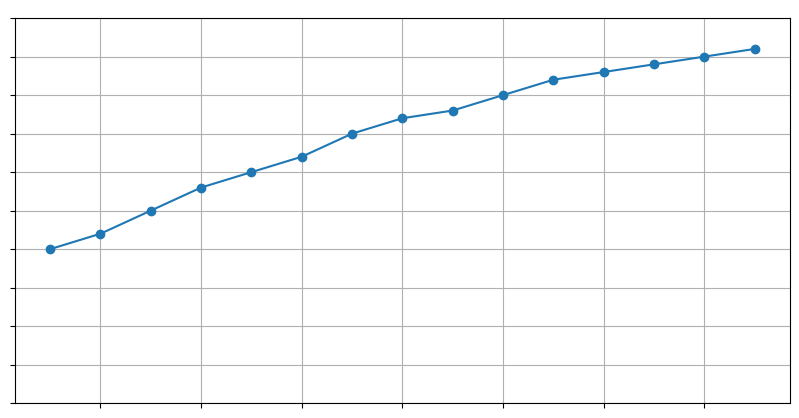

In [176]:
# 假设test_accuracies是你迭代计算得到的测试准确率列表
test_accuracies

# 绘制测试准确率的折线图
plt.figure(figsize=(10, 5))
plt.plot(range(1, 16), test_accuracies, marker='o')
plt.title('Test Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)

# 设置y轴的刻度范围和标签
plt.yticks(range(50, 101, 5))  # 从50%到100%，每5%一个刻度

plt.show()

In [141]:
subset_val_dataset

In [135]:
dataset.val

 ...]

In [121]:
# 假设probabilities是一个大小为(n_samples, n_classes)的tensor
# 示例

max_probs, max_indices = find_max_prob_samples_by_class(tip_probabilities)
print("Max probabilities by class:", max_probs)
print("Indices of samples with max probabilities:", max_indices)
print(tip_probabilities[max_indices])

Max probabilities by class: tensor([0.9688, 0.9814, 0.9092, 0.9824, 0.9917, 0.9146, 0.9507, 0.9644, 0.9312,
        0.9897], device='cuda:0', dtype=torch.float16)
Indices of samples with max probabilities: tensor([   3, 1631, 2300, 3171, 3778, 4538, 5452, 5701, 6973, 7425],
       device='cuda:0')
tensor([[9.6875e-01, 5.1651e-03, 1.6766e-03, 7.7515e-03, 2.6941e-04, 3.7193e-03,
         9.3536e-03, 1.0490e-03, 1.3266e-03, 8.0442e-04],
        [2.1255e-04, 9.8145e-01, 5.0485e-05, 1.6718e-03, 3.0160e-05, 1.1978e-02,
         1.6558e-04, 5.2929e-05, 8.2779e-04, 3.4847e-03],
        [1.8396e-03, 2.3849e-02, 9.0918e-01, 7.5073e-03, 1.1330e-03, 5.8441e-03,
         8.9111e-03, 7.8659e-03, 3.1586e-02, 2.2545e-03],
        [3.8528e-04, 4.6959e-03, 2.1958e-04, 9.8242e-01, 1.4772e-03, 4.9210e-03,
         2.7180e-03, 1.9073e-04, 2.5139e-03, 2.4891e-04],
        [5.8711e-05, 3.3808e-04, 1.4997e-04, 9.7752e-04, 9.9170e-01, 1.0633e-04,
         3.1257e-04, 5.8060e-03, 3.5429e-04, 3.3975e-05],
      

In [122]:
tip_probabilities.shape

torch.Size([8100, 10])

In [ ]:
for idx in max_indices:
    datum = dataset.val[idx]

In [98]:
# ------------------------------------------ Tip-Adapter-F ------------------------------------------
run_tip_adapter_F(cfg, cache_keys, cache_values, val_features, val_labels, test_features, test_labels, clip_weights, clip_model, train_loader_F)

Train Epoch: 0 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.57s/it]


LR: 0.001000, Acc: 0.6625 (106.0/160), Loss: 0.9985
**** Tip-Adapter-F's test accuracy: 57.53. ****

Train Epoch: 1 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.80s/it]


LR: 0.000999, Acc: 0.5875 (94.0/160), Loss: 2.6113
**** Tip-Adapter-F's test accuracy: 44.28. ****

Train Epoch: 2 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.49s/it]


LR: 0.000998, Acc: 0.4562 (73.0/160), Loss: 3.0195
**** Tip-Adapter-F's test accuracy: 46.84. ****

Train Epoch: 3 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.91s/it]


LR: 0.000996, Acc: 0.5563 (89.0/160), Loss: 1.8447
**** Tip-Adapter-F's test accuracy: 61.11. ****

Train Epoch: 4 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.26s/it]


LR: 0.000994, Acc: 0.6937 (111.0/160), Loss: 1.0059
**** Tip-Adapter-F's test accuracy: 63.74. ****

Train Epoch: 5 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.71s/it]


LR: 0.000991, Acc: 0.7188 (115.0/160), Loss: 0.7490
**** Tip-Adapter-F's test accuracy: 74.49. ****

Train Epoch: 6 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.77s/it]


LR: 0.000988, Acc: 0.8000 (128.0/160), Loss: 0.5625
**** Tip-Adapter-F's test accuracy: 75.38. ****

Train Epoch: 7 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.17s/it]


LR: 0.000984, Acc: 0.7812 (125.0/160), Loss: 0.7334
**** Tip-Adapter-F's test accuracy: 73.43. ****

Train Epoch: 8 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.47s/it]


LR: 0.000980, Acc: 0.7875 (126.0/160), Loss: 0.7588
**** Tip-Adapter-F's test accuracy: 72.74. ****

Train Epoch: 9 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.86s/it]


LR: 0.000976, Acc: 0.7688 (123.0/160), Loss: 0.7534
**** Tip-Adapter-F's test accuracy: 73.33. ****

Train Epoch: 10 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.86s/it]


LR: 0.000970, Acc: 0.8375 (134.0/160), Loss: 0.6245
**** Tip-Adapter-F's test accuracy: 75.41. ****

Train Epoch: 11 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.09s/it]


LR: 0.000965, Acc: 0.8313 (133.0/160), Loss: 0.5312
**** Tip-Adapter-F's test accuracy: 76.99. ****

Train Epoch: 12 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.64s/it]


LR: 0.000959, Acc: 0.8625 (138.0/160), Loss: 0.5073
**** Tip-Adapter-F's test accuracy: 78.64. ****

Train Epoch: 13 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.98s/it]


LR: 0.000952, Acc: 0.8688 (139.0/160), Loss: 0.3884
**** Tip-Adapter-F's test accuracy: 80.40. ****

Train Epoch: 14 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.39s/it]


LR: 0.000946, Acc: 0.8750 (140.0/160), Loss: 0.3376
**** Tip-Adapter-F's test accuracy: 81.47. ****

Train Epoch: 15 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.02s/it]


LR: 0.000938, Acc: 0.9125 (146.0/160), Loss: 0.2664
**** Tip-Adapter-F's test accuracy: 82.19. ****

Train Epoch: 16 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.71s/it]


LR: 0.000930, Acc: 0.9187 (147.0/160), Loss: 0.2605
**** Tip-Adapter-F's test accuracy: 82.65. ****

Train Epoch: 17 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.85s/it]


LR: 0.000922, Acc: 0.9500 (152.0/160), Loss: 0.1743
**** Tip-Adapter-F's test accuracy: 82.44. ****

Train Epoch: 18 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.51s/it]


LR: 0.000914, Acc: 0.9437 (151.0/160), Loss: 0.2140
**** Tip-Adapter-F's test accuracy: 82.67. ****

Train Epoch: 19 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.17s/it]


LR: 0.000905, Acc: 0.9375 (150.0/160), Loss: 0.1848
**** Tip-Adapter-F's test accuracy: 82.90. ****

Train Epoch: 20 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.21s/it]


LR: 0.000895, Acc: 0.9125 (146.0/160), Loss: 0.2629
**** Tip-Adapter-F's test accuracy: 82.75. ****

Train Epoch: 21 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.82s/it]


LR: 0.000885, Acc: 0.9375 (150.0/160), Loss: 0.1765
**** Tip-Adapter-F's test accuracy: 82.46. ****

Train Epoch: 22 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.69s/it]


LR: 0.000875, Acc: 0.9250 (148.0/160), Loss: 0.1705
**** Tip-Adapter-F's test accuracy: 81.96. ****

Train Epoch: 23 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.86s/it]


LR: 0.000864, Acc: 0.9250 (148.0/160), Loss: 0.1925
**** Tip-Adapter-F's test accuracy: 81.16. ****

Train Epoch: 24 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.18s/it]


LR: 0.000854, Acc: 0.9563 (153.0/160), Loss: 0.2018
**** Tip-Adapter-F's test accuracy: 80.59. ****

Train Epoch: 25 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.10s/it]


LR: 0.000842, Acc: 0.9313 (149.0/160), Loss: 0.1809
**** Tip-Adapter-F's test accuracy: 80.63. ****

Train Epoch: 26 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.98s/it]


LR: 0.000831, Acc: 0.9375 (150.0/160), Loss: 0.1996
**** Tip-Adapter-F's test accuracy: 81.17. ****

Train Epoch: 27 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.69s/it]


LR: 0.000819, Acc: 0.9625 (154.0/160), Loss: 0.1552
**** Tip-Adapter-F's test accuracy: 81.74. ****

Train Epoch: 28 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.70s/it]


LR: 0.000806, Acc: 0.9437 (151.0/160), Loss: 0.1611
**** Tip-Adapter-F's test accuracy: 82.05. ****

Train Epoch: 29 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.24s/it]


LR: 0.000794, Acc: 0.9688 (155.0/160), Loss: 0.1464
**** Tip-Adapter-F's test accuracy: 82.41. ****

Train Epoch: 30 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.69s/it]


LR: 0.000781, Acc: 0.9563 (153.0/160), Loss: 0.1625
**** Tip-Adapter-F's test accuracy: 82.80. ****

Train Epoch: 31 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.29s/it]


LR: 0.000768, Acc: 0.9563 (153.0/160), Loss: 0.1312
**** Tip-Adapter-F's test accuracy: 83.16. ****

Train Epoch: 32 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.47s/it]


LR: 0.000755, Acc: 0.9625 (154.0/160), Loss: 0.1287
**** Tip-Adapter-F's test accuracy: 83.32. ****

Train Epoch: 33 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.38s/it]


LR: 0.000741, Acc: 0.9563 (153.0/160), Loss: 0.1360
**** Tip-Adapter-F's test accuracy: 83.17. ****

Train Epoch: 34 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.62s/it]


LR: 0.000727, Acc: 0.9625 (154.0/160), Loss: 0.1401
**** Tip-Adapter-F's test accuracy: 83.17. ****

Train Epoch: 35 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.05s/it]


LR: 0.000713, Acc: 0.9563 (153.0/160), Loss: 0.1127
**** Tip-Adapter-F's test accuracy: 83.17. ****

Train Epoch: 36 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.29s/it]


LR: 0.000699, Acc: 0.9500 (152.0/160), Loss: 0.1273
**** Tip-Adapter-F's test accuracy: 83.60. ****

Train Epoch: 37 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.67s/it]


LR: 0.000684, Acc: 0.9812 (157.0/160), Loss: 0.0905
**** Tip-Adapter-F's test accuracy: 84.20. ****

Train Epoch: 38 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.46s/it]


LR: 0.000669, Acc: 0.9812 (157.0/160), Loss: 0.0987
**** Tip-Adapter-F's test accuracy: 84.69. ****

Train Epoch: 39 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.31s/it]


LR: 0.000655, Acc: 0.9750 (156.0/160), Loss: 0.0942
**** Tip-Adapter-F's test accuracy: 85.09. ****

Train Epoch: 40 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.86s/it]


LR: 0.000639, Acc: 0.9688 (155.0/160), Loss: 0.0969
**** Tip-Adapter-F's test accuracy: 85.22. ****

Train Epoch: 41 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.32s/it]


LR: 0.000624, Acc: 0.9812 (157.0/160), Loss: 0.0805
**** Tip-Adapter-F's test accuracy: 85.19. ****

Train Epoch: 42 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.57s/it]


LR: 0.000609, Acc: 0.9688 (155.0/160), Loss: 0.1315
**** Tip-Adapter-F's test accuracy: 85.07. ****

Train Epoch: 43 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.30s/it]


LR: 0.000594, Acc: 0.9625 (154.0/160), Loss: 0.1107
**** Tip-Adapter-F's test accuracy: 84.91. ****

Train Epoch: 44 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.78s/it]


LR: 0.000578, Acc: 0.9750 (156.0/160), Loss: 0.1010
**** Tip-Adapter-F's test accuracy: 84.89. ****

Train Epoch: 45 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.86s/it]


LR: 0.000563, Acc: 0.9812 (157.0/160), Loss: 0.0640
**** Tip-Adapter-F's test accuracy: 84.73. ****

Train Epoch: 46 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.70s/it]


LR: 0.000547, Acc: 0.9688 (155.0/160), Loss: 0.0980
**** Tip-Adapter-F's test accuracy: 84.60. ****

Train Epoch: 47 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.50s/it]


LR: 0.000531, Acc: 0.9625 (154.0/160), Loss: 0.1055
**** Tip-Adapter-F's test accuracy: 84.65. ****

Train Epoch: 48 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.68s/it]


LR: 0.000516, Acc: 0.9875 (158.0/160), Loss: 0.0988
**** Tip-Adapter-F's test accuracy: 84.94. ****

Train Epoch: 49 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.05s/it]


LR: 0.000500, Acc: 0.9625 (154.0/160), Loss: 0.1035
**** Tip-Adapter-F's test accuracy: 85.15. ****

Train Epoch: 50 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.14s/it]


LR: 0.000484, Acc: 0.9812 (157.0/160), Loss: 0.0838
**** Tip-Adapter-F's test accuracy: 85.20. ****

Train Epoch: 51 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.72s/it]


LR: 0.000469, Acc: 0.9938 (159.0/160), Loss: 0.0782
**** Tip-Adapter-F's test accuracy: 85.25. ****

Train Epoch: 52 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.81s/it]


LR: 0.000453, Acc: 0.9812 (157.0/160), Loss: 0.0876
**** Tip-Adapter-F's test accuracy: 85.25. ****

Train Epoch: 53 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.27s/it]


LR: 0.000437, Acc: 0.9688 (155.0/160), Loss: 0.1115
**** Tip-Adapter-F's test accuracy: 85.38. ****

Train Epoch: 54 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.50s/it]


LR: 0.000422, Acc: 0.9875 (158.0/160), Loss: 0.0836
**** Tip-Adapter-F's test accuracy: 85.20. ****

Train Epoch: 55 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.88s/it]


LR: 0.000406, Acc: 0.9563 (153.0/160), Loss: 0.1028
**** Tip-Adapter-F's test accuracy: 85.07. ****

Train Epoch: 56 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.51s/it]


LR: 0.000391, Acc: 0.9938 (159.0/160), Loss: 0.0771
**** Tip-Adapter-F's test accuracy: 84.99. ****

Train Epoch: 57 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.45s/it]


LR: 0.000376, Acc: 0.9750 (156.0/160), Loss: 0.0880
**** Tip-Adapter-F's test accuracy: 84.88. ****

Train Epoch: 58 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.74s/it]


LR: 0.000361, Acc: 0.9875 (158.0/160), Loss: 0.0843
**** Tip-Adapter-F's test accuracy: 84.68. ****

Train Epoch: 59 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.07s/it]


LR: 0.000345, Acc: 0.9812 (157.0/160), Loss: 0.0714
**** Tip-Adapter-F's test accuracy: 84.51. ****

Train Epoch: 60 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.52s/it]


LR: 0.000331, Acc: 0.9938 (159.0/160), Loss: 0.0745
**** Tip-Adapter-F's test accuracy: 84.42. ****

Train Epoch: 61 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.40s/it]


LR: 0.000316, Acc: 0.9938 (159.0/160), Loss: 0.0669
**** Tip-Adapter-F's test accuracy: 84.46. ****

Train Epoch: 62 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.46s/it]


LR: 0.000301, Acc: 0.9750 (156.0/160), Loss: 0.1055
**** Tip-Adapter-F's test accuracy: 84.51. ****

Train Epoch: 63 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.08s/it]


LR: 0.000287, Acc: 0.9875 (158.0/160), Loss: 0.0732
**** Tip-Adapter-F's test accuracy: 84.56. ****

Train Epoch: 64 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.49s/it]


LR: 0.000273, Acc: 0.9750 (156.0/160), Loss: 0.0953
**** Tip-Adapter-F's test accuracy: 84.58. ****

Train Epoch: 65 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.89s/it]


LR: 0.000259, Acc: 0.9875 (158.0/160), Loss: 0.0726
**** Tip-Adapter-F's test accuracy: 84.67. ****

Train Epoch: 66 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.84s/it]


LR: 0.000245, Acc: 0.9688 (155.0/160), Loss: 0.0765
**** Tip-Adapter-F's test accuracy: 84.77. ****

Train Epoch: 67 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.81s/it]


LR: 0.000232, Acc: 0.9563 (153.0/160), Loss: 0.0984
**** Tip-Adapter-F's test accuracy: 84.78. ****

Train Epoch: 68 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.65s/it]


LR: 0.000219, Acc: 0.9875 (158.0/160), Loss: 0.0715
**** Tip-Adapter-F's test accuracy: 84.77. ****

Train Epoch: 69 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.37s/it]


LR: 0.000206, Acc: 0.9875 (158.0/160), Loss: 0.0788
**** Tip-Adapter-F's test accuracy: 84.81. ****

Train Epoch: 70 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.90s/it]


LR: 0.000194, Acc: 0.9812 (157.0/160), Loss: 0.0906
**** Tip-Adapter-F's test accuracy: 84.91. ****

Train Epoch: 71 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.45s/it]


LR: 0.000181, Acc: 0.9812 (157.0/160), Loss: 0.0863
**** Tip-Adapter-F's test accuracy: 84.96. ****

Train Epoch: 72 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.30s/it]


LR: 0.000169, Acc: 0.9812 (157.0/160), Loss: 0.0821
**** Tip-Adapter-F's test accuracy: 84.94. ****

Train Epoch: 73 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.69s/it]


LR: 0.000158, Acc: 0.9812 (157.0/160), Loss: 0.0812
**** Tip-Adapter-F's test accuracy: 84.91. ****

Train Epoch: 74 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.16s/it]


LR: 0.000146, Acc: 0.9875 (158.0/160), Loss: 0.0694
**** Tip-Adapter-F's test accuracy: 84.99. ****

Train Epoch: 75 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.48s/it]


LR: 0.000136, Acc: 0.9688 (155.0/160), Loss: 0.0864
**** Tip-Adapter-F's test accuracy: 85.00. ****

Train Epoch: 76 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.61s/it]


LR: 0.000125, Acc: 1.0000 (160.0/160), Loss: 0.0654
**** Tip-Adapter-F's test accuracy: 85.01. ****

Train Epoch: 77 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.83s/it]


LR: 0.000115, Acc: 0.9750 (156.0/160), Loss: 0.0815
**** Tip-Adapter-F's test accuracy: 85.00. ****

Train Epoch: 78 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.50s/it]


LR: 0.000105, Acc: 0.9812 (157.0/160), Loss: 0.0742
**** Tip-Adapter-F's test accuracy: 85.05. ****

Train Epoch: 79 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.25s/it]


LR: 0.000095, Acc: 0.9812 (157.0/160), Loss: 0.0926
**** Tip-Adapter-F's test accuracy: 85.01. ****

Train Epoch: 80 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.37s/it]


LR: 0.000086, Acc: 0.9938 (159.0/160), Loss: 0.0607
**** Tip-Adapter-F's test accuracy: 85.01. ****

Train Epoch: 81 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.51s/it]


LR: 0.000078, Acc: 0.9688 (155.0/160), Loss: 0.0951
**** Tip-Adapter-F's test accuracy: 85.05. ****

Train Epoch: 82 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.58s/it]


LR: 0.000070, Acc: 0.9812 (157.0/160), Loss: 0.0687
**** Tip-Adapter-F's test accuracy: 85.07. ****

Train Epoch: 83 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.66s/it]


LR: 0.000062, Acc: 0.9750 (156.0/160), Loss: 0.0692
**** Tip-Adapter-F's test accuracy: 85.09. ****

Train Epoch: 84 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.30s/it]


LR: 0.000054, Acc: 0.9688 (155.0/160), Loss: 0.0802
**** Tip-Adapter-F's test accuracy: 85.09. ****

Train Epoch: 85 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.70s/it]


LR: 0.000048, Acc: 0.9938 (159.0/160), Loss: 0.0763
**** Tip-Adapter-F's test accuracy: 85.09. ****

Train Epoch: 86 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.63s/it]


LR: 0.000041, Acc: 0.9938 (159.0/160), Loss: 0.0550
**** Tip-Adapter-F's test accuracy: 85.10. ****

Train Epoch: 87 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.60s/it]


LR: 0.000035, Acc: 0.9875 (158.0/160), Loss: 0.0700
**** Tip-Adapter-F's test accuracy: 85.09. ****

Train Epoch: 88 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.62s/it]


LR: 0.000030, Acc: 0.9875 (158.0/160), Loss: 0.0676
**** Tip-Adapter-F's test accuracy: 85.10. ****

Train Epoch: 89 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.61s/it]


LR: 0.000024, Acc: 0.9938 (159.0/160), Loss: 0.0612
**** Tip-Adapter-F's test accuracy: 85.11. ****

Train Epoch: 90 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.29s/it]


LR: 0.000020, Acc: 0.9688 (155.0/160), Loss: 0.0964
**** Tip-Adapter-F's test accuracy: 85.11. ****

Train Epoch: 91 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.90s/it]


LR: 0.000016, Acc: 0.9938 (159.0/160), Loss: 0.0572
**** Tip-Adapter-F's test accuracy: 85.12. ****

Train Epoch: 92 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.72s/it]


LR: 0.000012, Acc: 0.9812 (157.0/160), Loss: 0.0891
**** Tip-Adapter-F's test accuracy: 85.11. ****

Train Epoch: 93 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.94s/it]


LR: 0.000009, Acc: 0.9875 (158.0/160), Loss: 0.0748
**** Tip-Adapter-F's test accuracy: 85.11. ****

Train Epoch: 94 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.27s/it]


LR: 0.000006, Acc: 0.9875 (158.0/160), Loss: 0.0679
**** Tip-Adapter-F's test accuracy: 85.11. ****

Train Epoch: 95 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.76s/it]


LR: 0.000004, Acc: 0.9812 (157.0/160), Loss: 0.0835
**** Tip-Adapter-F's test accuracy: 85.11. ****

Train Epoch: 96 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.84s/it]


LR: 0.000002, Acc: 0.9938 (159.0/160), Loss: 0.0594
**** Tip-Adapter-F's test accuracy: 85.11. ****

Train Epoch: 97 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.32s/it]


LR: 0.000001, Acc: 0.9750 (156.0/160), Loss: 0.0887
**** Tip-Adapter-F's test accuracy: 85.11. ****

Train Epoch: 98 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.90s/it]


LR: 0.000000, Acc: 0.9875 (158.0/160), Loss: 0.0681
**** Tip-Adapter-F's test accuracy: 85.11. ****

Train Epoch: 99 / 100


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.93s/it]


LR: 0.000000, Acc: 0.9875 (158.0/160), Loss: 0.0613
**** Tip-Adapter-F's test accuracy: 85.11. ****

**** After fine-tuning, Tip-Adapter-F's best test accuracy: 85.38, at epoch: 53. ****


-------- Searching hyperparameters on the val set. --------
New best setting, beta: 0.10, alpha: 0.10; accuracy: 37.41
New best setting, beta: 0.10, alpha: 0.59; accuracy: 45.43
New best setting, beta: 0.10, alpha: 1.09; accuracy: 54.20
New best setting, beta: 0.10, alpha: 1.59; accuracy: 59.22
New best setting, beta: 0.10, alpha: 2.08; accuracy: 63.37
New best setting, beta: 0.10, alpha: 2.58; accuracy: 66.85
New best setting, beta: 0.10, alpha: 3.07; accuracy: 69.31
New best setting, beta: 0.10, alpha: 3.56; accuracy: 71.30
New best setting, beta: 0.10, alpha: 4.06; accuracy: 73.48
New best setting, beta: 0.10, alpha: 4.55; accuracy: 74.59
New best setting, beta: 0.10, alpha: 5.05; accuracy: 76.15
New best setting, beta: 0.10, alpha: 5.54; accuracy: 77.17
New best setting, beta: 0.10, alpha: 6.04; 

In [101]:
# 假设 val_features 是你的特征向量，val_labels 是每个特征向量对应的标签
# 将它们从 PyTorch Tensor 转换为 NumPy 数组

clip_logits = 100. * val_features @ clip_weights


In [102]:
features_np = clip_logits.cpu().detach().numpy()  # 假设特征向量在CUDA上
labels_np = val_labels.cpu().numpy()  # 假设标签也在CUDA上，并已存在

# 使用t-SNE进行降维，这里的 n_components=2 表示我们将特征降到二维
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features_np)

# 接下来，我们可以根据类别绘制这些点
unique_labels = np.unique(labels_np)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))



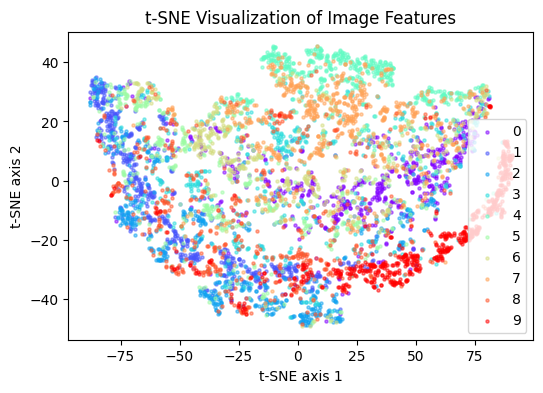

In [104]:
%matplotlib inline

plt.figure(figsize=(6, 4))
for i, label in enumerate(unique_labels):
    idxs = labels_np == label
    plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1], color=colors[i], label=str(label), alpha=0.5,s=5)

plt.title('t-SNE Visualization of Image Features')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.legend()
plt.show()

In [106]:
 # Tip-Adapter
beta, alpha = cfg['init_beta'], cfg['init_alpha']
    
affinity = val_features @ cache_keys
cache_logits = ((-1) * (beta - beta * affinity)).exp() @ cache_values
    
tip_logits = clip_logits + cache_logits * alpha

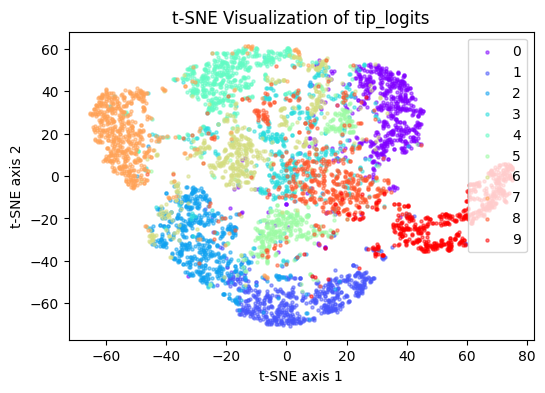

In [107]:
features_np = tip_logits.cpu().detach().numpy()  # 假设特征向量在CUDA上
labels_np = val_labels.cpu().numpy()  # 假设标签也在CUDA上，并已存在

# 使用t-SNE进行降维，这里的 n_components=2 表示我们将特征降到二维
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features_np)

# 接下来，我们可以根据类别绘制这些点
unique_labels = np.unique(labels_np)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(6, 4))
for i, label in enumerate(unique_labels):
    idxs = labels_np == label
    plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1], color=colors[i], label=str(label), alpha=0.5,s=5)

plt.title('t-SNE Visualization of tip_logits')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.legend()
plt.show()